Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58ddc000 @  0x7efc4f8372a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
!wget https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true -O dataset.hdf5

--2019-01-03 16:47:30--  https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5 [following]
--2019-01-03 16:47:30--  https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5 [following]
--2019-01-03 16:47:31--  https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connecte

In [3]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [15]:
import torch
import torch.nn as nn

# https://github.com/pytorch/examples/blob/master/dcgan/main.py

image_shape = (4, 28, 28)
latent_shape = (100, 1, 1)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)


# Generator
G = nn.Sequential(
        # ConvTranspose2d: next width or height := (prev_height - 1) * stride + kernel_size - padding * 2

        # https://distill.pub/2016/deconv-checkerboard/

        # Shape: 100 x 1 x 1
        nn.ConvTranspose2d(100, 128, kernel_size=7, stride=1, padding=0),
        nn.ReLU(True),
        nn.BatchNorm2d(128), # nn.utils.SpectralNorm(),
        # Shape: 128 x 7 x 7
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(64), # nn.utils.SpectralNorm(),
        # Shape: 64 x 14 x 14
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(32), # nn.utils.SpectralNorm(),
        # Shape: 32 x 28 x 28
        nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2),
        nn.Tanh()
        # Shape: 4 x 28 x 28
)

# Discriminator
D = nn.Sequential(
        # Shape: 4 x 28 x 28
        nn.Conv2d(4, 32, kernel_size=5, stride=1, padding=2),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32),
        #nn.Dropout(0.2),
        # Shape: 32 x 28 x 28
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64),
        #nn.Dropout(0.2),
        # Shape: 64 x 14 x 14
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # => batch, 64, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(128),
        #nn.Dropout(0.2),
        # Shape: 128 x 7 x 7
        nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0), # => batch, 128, 7, 7
        nn.Sigmoid()
        # Shape: 100 x 1 x 1
)


# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(123, *latent_shape))
assert(g_out.size() == torch.randn(123, *image_shape).size())
print("DISCRIMINATOR")
d_out = D(g_out)
assert(d_out.size() == torch.randn(123, *((1,)*len(image_shape))).size())
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
ConvTranspose2d:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 128, 7, 7])
ReLU:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 128, 7, 7])
BatchNorm2d:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 128, 7, 7])
ConvTranspose2d:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 64, 14, 14])
ReLU:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 64, 14, 14])
BatchNorm2d:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 64, 14, 14])
ConvTranspose2d:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 32, 28, 28])
ReLU:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 32, 28, 28])
BatchNorm2d:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 32, 28, 28])
ConvTranspose2d:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 4, 28, 28])
Tanh:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 4, 28, 28])
Sequential:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 4, 28, 28])
DISCRIMINATOR
Conv2d:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 32, 28, 28])
LeakyR

In [0]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [10]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.Tensor(np.moveaxis(dataset[:50000], 3, 1)).to(device)
    print(preloaded_data.size())


torch.Size([50000, 4, 28, 28])


Epoch [0/50], Step [1/10], d_loss: 1.5108, g_loss: 1.4201, D(x): 0.55, D(G(z)): 0.43
Epoch [0/50], Step [2/10], d_loss: 1.1449, g_loss: 1.1636, D(x): 0.88, D(G(z)): 0.53
Epoch [0/50], Step [3/10], d_loss: 1.2671, g_loss: 0.9582, D(x): 0.95, D(G(z)): 0.60
Epoch [0/50], Step [4/10], d_loss: 1.4527, g_loss: 0.8100, D(x): 0.97, D(G(z)): 0.66
Epoch [0/50], Step [5/10], d_loss: 1.6409, g_loss: 0.6958, D(x): 0.98, D(G(z)): 0.71
Epoch [0/50], Step [6/10], d_loss: 1.8313, g_loss: 0.6098, D(x): 0.98, D(G(z)): 0.75
Epoch [0/50], Step [7/10], d_loss: 1.9919, g_loss: 0.5360, D(x): 0.99, D(G(z)): 0.78
Epoch [0/50], Step [8/10], d_loss: 2.1126, g_loss: 0.5080, D(x): 0.99, D(G(z)): 0.81
Epoch [0/50], Step [9/10], d_loss: 2.2138, g_loss: 0.4928, D(x): 0.98, D(G(z)): 0.82
Epoch [0/50], Step [10/10], d_loss: 2.2169, g_loss: 0.5211, D(x): 0.98, D(G(z)): 0.82


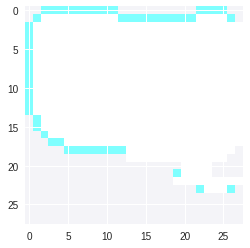

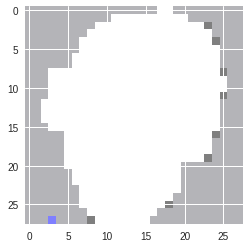

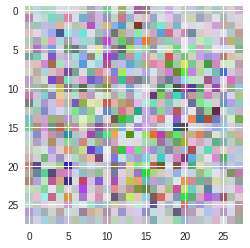

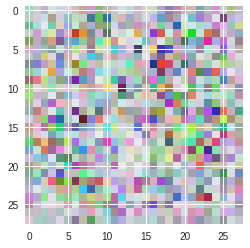

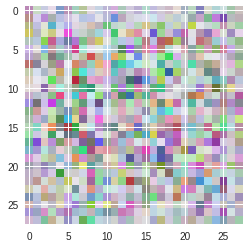

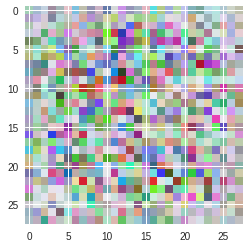

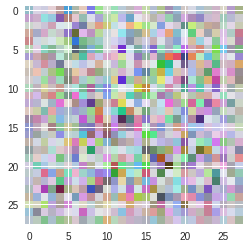

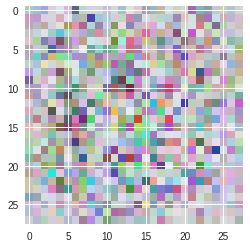

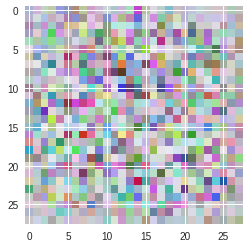

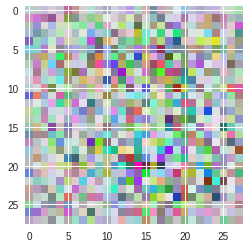

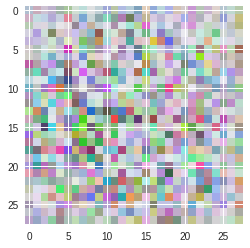

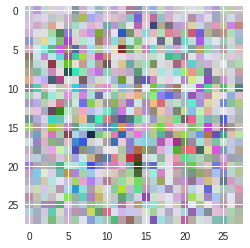

Epoch [1/50], Step [1/10], d_loss: 2.1724, g_loss: 0.5861, D(x): 0.98, D(G(z)): 0.81
Epoch [1/50], Step [2/10], d_loss: 2.0723, g_loss: 0.6895, D(x): 0.95, D(G(z)): 0.79
Epoch [1/50], Step [3/10], d_loss: 1.8603, g_loss: 0.9096, D(x): 0.92, D(G(z)): 0.74
Epoch [1/50], Step [4/10], d_loss: 1.7327, g_loss: 1.1576, D(x): 0.87, D(G(z)): 0.68
Epoch [1/50], Step [5/10], d_loss: 1.5537, g_loss: 1.4558, D(x): 0.84, D(G(z)): 0.62
Epoch [1/50], Step [6/10], d_loss: 1.3330, g_loss: 1.8170, D(x): 0.82, D(G(z)): 0.53
Epoch [1/50], Step [7/10], d_loss: 1.1208, g_loss: 2.1912, D(x): 0.82, D(G(z)): 0.45
Epoch [1/50], Step [8/10], d_loss: 0.9339, g_loss: 2.5003, D(x): 0.82, D(G(z)): 0.38
Epoch [1/50], Step [9/10], d_loss: 0.7597, g_loss: 2.7894, D(x): 0.85, D(G(z)): 0.32
Epoch [1/50], Step [10/10], d_loss: 0.6248, g_loss: 3.0127, D(x): 0.88, D(G(z)): 0.28


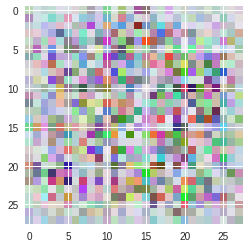

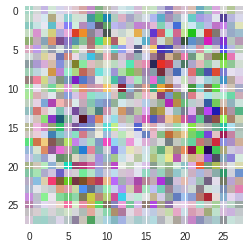

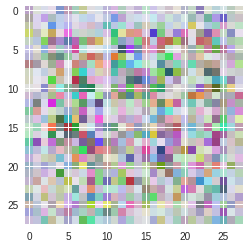

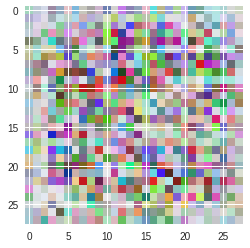

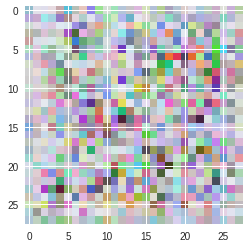

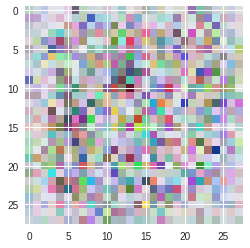

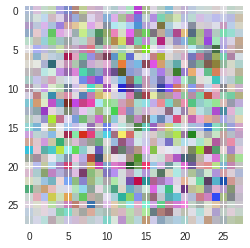

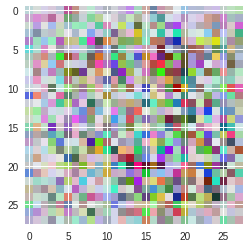

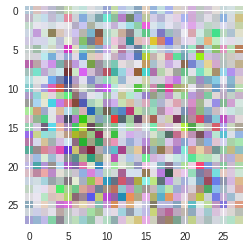

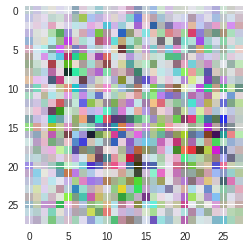

Epoch [2/50], Step [1/10], d_loss: 0.5417, g_loss: 3.1455, D(x): 0.90, D(G(z)): 0.26
Epoch [2/50], Step [2/10], d_loss: 0.5317, g_loss: 3.1655, D(x): 0.91, D(G(z)): 0.25
Epoch [2/50], Step [3/10], d_loss: 0.5126, g_loss: 3.1863, D(x): 0.93, D(G(z)): 0.26
Epoch [2/50], Step [4/10], d_loss: 0.5163, g_loss: 3.1229, D(x): 0.94, D(G(z)): 0.27
Epoch [2/50], Step [5/10], d_loss: 0.5422, g_loss: 3.0672, D(x): 0.95, D(G(z)): 0.29
Epoch [2/50], Step [6/10], d_loss: 0.5681, g_loss: 2.9730, D(x): 0.97, D(G(z)): 0.31
Epoch [2/50], Step [7/10], d_loss: 0.5654, g_loss: 2.9581, D(x): 0.98, D(G(z)): 0.33
Epoch [2/50], Step [8/10], d_loss: 0.6157, g_loss: 2.9322, D(x): 0.98, D(G(z)): 0.35
Epoch [2/50], Step [9/10], d_loss: 0.6603, g_loss: 2.9056, D(x): 0.98, D(G(z)): 0.36
Epoch [2/50], Step [10/10], d_loss: 0.6642, g_loss: 2.9382, D(x): 0.99, D(G(z)): 0.37


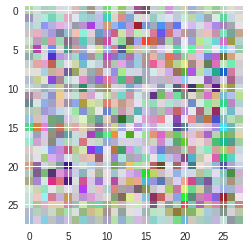

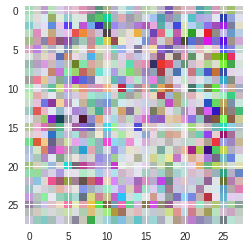

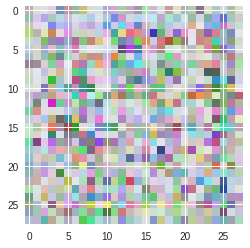

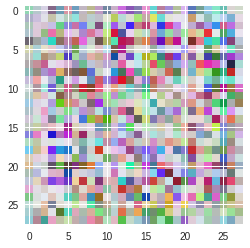

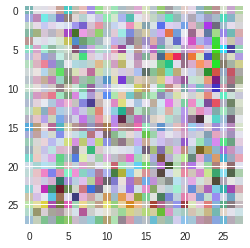

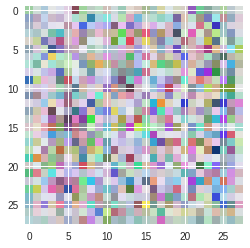

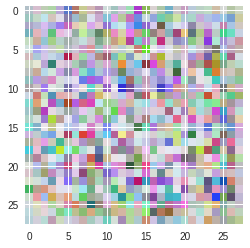

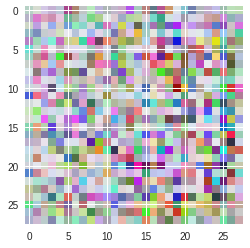

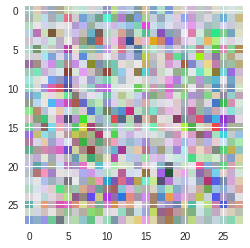

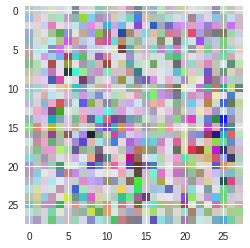

Epoch [3/50], Step [1/10], d_loss: 0.6976, g_loss: 2.9350, D(x): 0.99, D(G(z)): 0.38
Epoch [3/50], Step [2/10], d_loss: 0.7193, g_loss: 2.9930, D(x): 0.99, D(G(z)): 0.38
Epoch [3/50], Step [3/10], d_loss: 0.7193, g_loss: 3.0425, D(x): 0.99, D(G(z)): 0.38
Epoch [3/50], Step [4/10], d_loss: 0.7576, g_loss: 3.0567, D(x): 0.99, D(G(z)): 0.39
Epoch [3/50], Step [5/10], d_loss: 0.7662, g_loss: 3.1088, D(x): 0.99, D(G(z)): 0.39
Epoch [3/50], Step [6/10], d_loss: 0.7612, g_loss: 3.2234, D(x): 0.99, D(G(z)): 0.39
Epoch [3/50], Step [7/10], d_loss: 0.7438, g_loss: 3.3466, D(x): 0.99, D(G(z)): 0.38
Epoch [3/50], Step [8/10], d_loss: 0.7291, g_loss: 3.5046, D(x): 1.00, D(G(z)): 0.37
Epoch [3/50], Step [9/10], d_loss: 0.7119, g_loss: 3.7089, D(x): 1.00, D(G(z)): 0.35
Epoch [3/50], Step [10/10], d_loss: 0.6410, g_loss: 3.9403, D(x): 1.00, D(G(z)): 0.33


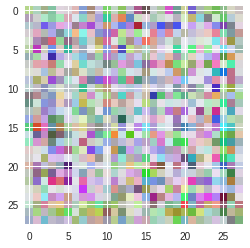

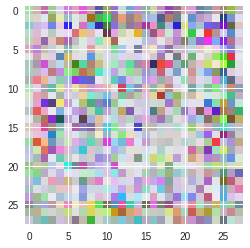

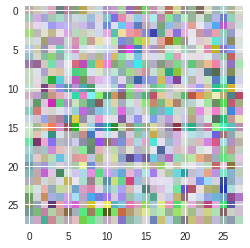

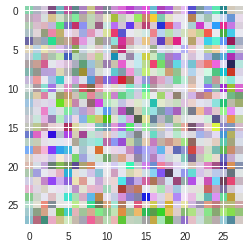

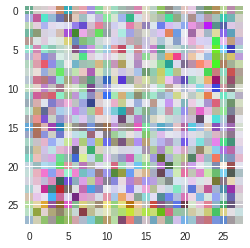

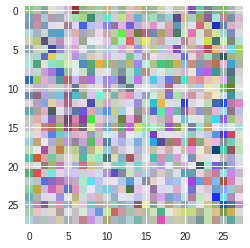

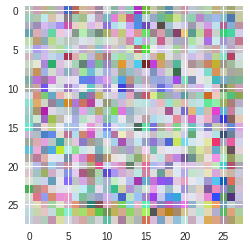

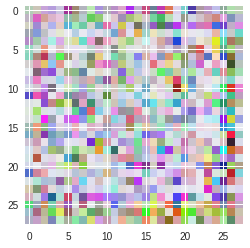

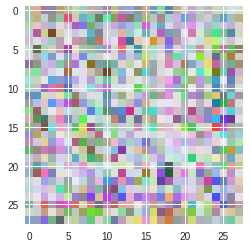

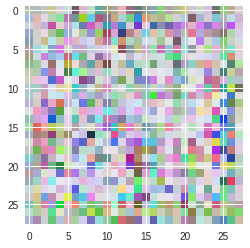

Epoch [4/50], Step [1/10], d_loss: 0.5933, g_loss: 4.1890, D(x): 1.00, D(G(z)): 0.31
Epoch [4/50], Step [2/10], d_loss: 0.5383, g_loss: 4.4571, D(x): 1.00, D(G(z)): 0.29
Epoch [4/50], Step [3/10], d_loss: 0.4911, g_loss: 4.6951, D(x): 1.00, D(G(z)): 0.27
Epoch [4/50], Step [4/10], d_loss: 0.4204, g_loss: 4.9968, D(x): 1.00, D(G(z)): 0.24
Epoch [4/50], Step [5/10], d_loss: 0.3689, g_loss: 5.2657, D(x): 1.00, D(G(z)): 0.21
Epoch [4/50], Step [6/10], d_loss: 0.3236, g_loss: 5.4881, D(x): 1.00, D(G(z)): 0.19
Epoch [4/50], Step [7/10], d_loss: 0.2807, g_loss: 5.6967, D(x): 1.00, D(G(z)): 0.18
Epoch [4/50], Step [8/10], d_loss: 0.2540, g_loss: 5.8422, D(x): 1.00, D(G(z)): 0.16
Epoch [4/50], Step [9/10], d_loss: 0.2553, g_loss: 5.9183, D(x): 1.00, D(G(z)): 0.16
Epoch [4/50], Step [10/10], d_loss: 0.2644, g_loss: 5.8876, D(x): 1.00, D(G(z)): 0.16


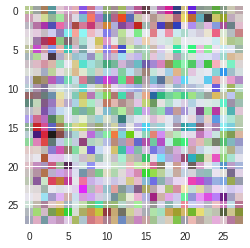

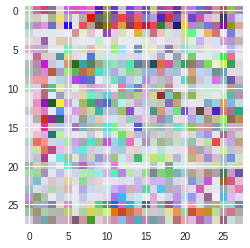

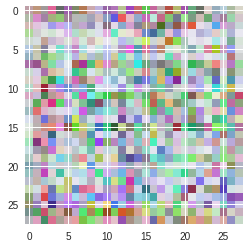

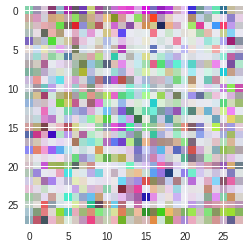

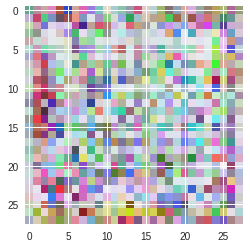

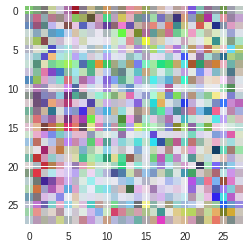

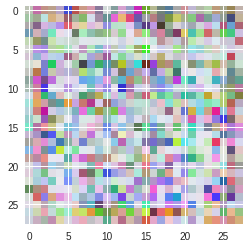

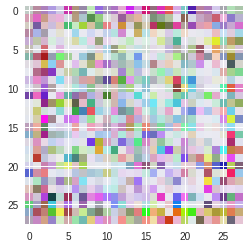

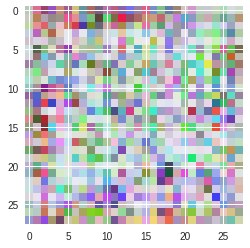

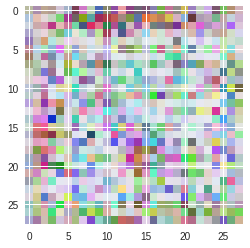

Epoch [5/50], Step [1/10], d_loss: 0.2931, g_loss: 5.7589, D(x): 1.00, D(G(z)): 0.18
Epoch [5/50], Step [2/10], d_loss: 0.3199, g_loss: 5.7561, D(x): 0.99, D(G(z)): 0.18
Epoch [5/50], Step [3/10], d_loss: 0.3578, g_loss: 5.7072, D(x): 0.99, D(G(z)): 0.20
Epoch [5/50], Step [4/10], d_loss: 0.4240, g_loss: 5.5939, D(x): 0.98, D(G(z)): 0.22
Epoch [5/50], Step [5/10], d_loss: 0.5145, g_loss: 5.4557, D(x): 0.97, D(G(z)): 0.25
Epoch [5/50], Step [6/10], d_loss: 0.5343, g_loss: 5.4736, D(x): 0.97, D(G(z)): 0.26
Epoch [5/50], Step [7/10], d_loss: 0.6100, g_loss: 5.3868, D(x): 0.96, D(G(z)): 0.28
Epoch [5/50], Step [8/10], d_loss: 0.6636, g_loss: 5.4571, D(x): 0.95, D(G(z)): 0.29
Epoch [5/50], Step [9/10], d_loss: 0.6919, g_loss: 5.4942, D(x): 0.95, D(G(z)): 0.30
Epoch [5/50], Step [10/10], d_loss: 0.7326, g_loss: 5.5037, D(x): 0.94, D(G(z)): 0.30


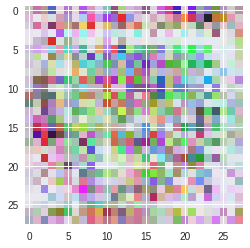

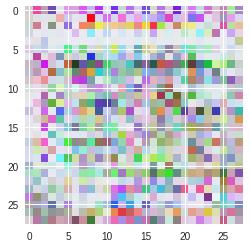

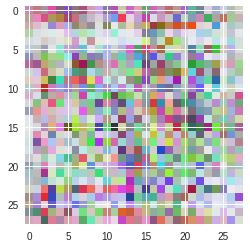

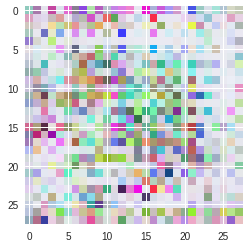

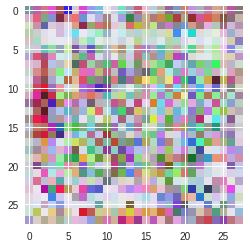

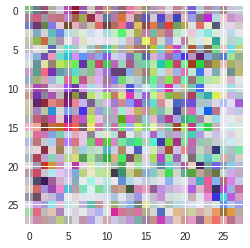

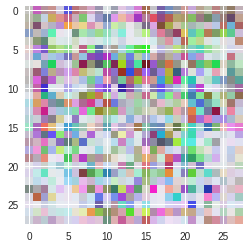

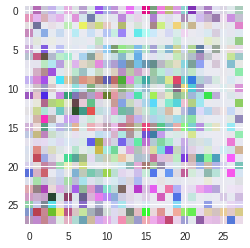

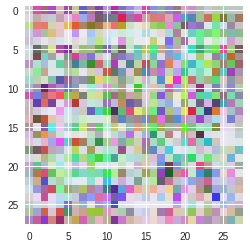

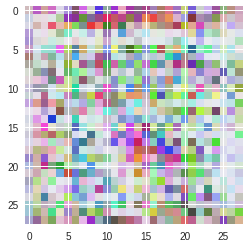

Epoch [6/50], Step [1/10], d_loss: 0.7619, g_loss: 5.4476, D(x): 0.95, D(G(z)): 0.32
Epoch [6/50], Step [2/10], d_loss: 0.8044, g_loss: 5.5377, D(x): 0.92, D(G(z)): 0.30
Epoch [6/50], Step [3/10], d_loss: 0.7865, g_loss: 5.5216, D(x): 0.92, D(G(z)): 0.30
Epoch [6/50], Step [4/10], d_loss: 0.8270, g_loss: 5.3776, D(x): 0.91, D(G(z)): 0.31
Epoch [6/50], Step [5/10], d_loss: 0.8227, g_loss: 5.3851, D(x): 0.90, D(G(z)): 0.30
Epoch [6/50], Step [6/10], d_loss: 0.7907, g_loss: 5.3662, D(x): 0.91, D(G(z)): 0.29
Epoch [6/50], Step [7/10], d_loss: 0.7846, g_loss: 5.2671, D(x): 0.92, D(G(z)): 0.30
Epoch [6/50], Step [8/10], d_loss: 0.8104, g_loss: 5.2459, D(x): 0.92, D(G(z)): 0.30
Epoch [6/50], Step [9/10], d_loss: 0.8193, g_loss: 5.1977, D(x): 0.92, D(G(z)): 0.30
Epoch [6/50], Step [10/10], d_loss: 0.7944, g_loss: 5.1989, D(x): 0.92, D(G(z)): 0.29


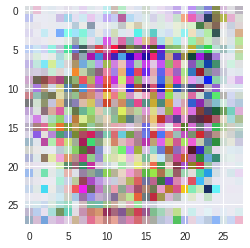

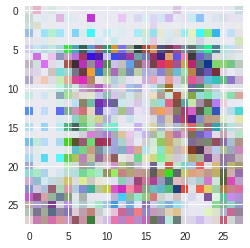

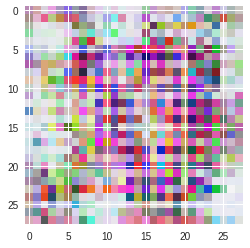

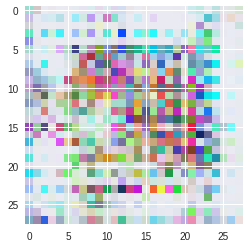

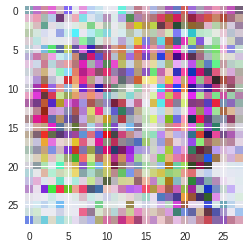

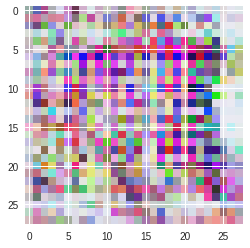

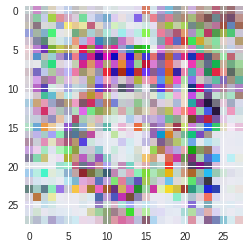

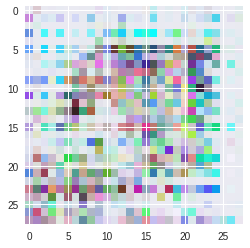

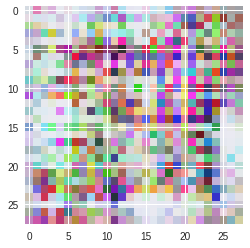

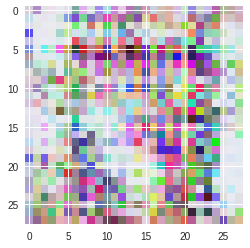

Epoch [7/50], Step [1/10], d_loss: 0.7973, g_loss: 5.2139, D(x): 0.93, D(G(z)): 0.29
Epoch [7/50], Step [2/10], d_loss: 0.8773, g_loss: 5.2798, D(x): 0.91, D(G(z)): 0.29
Epoch [7/50], Step [3/10], d_loss: 0.8715, g_loss: 5.2262, D(x): 0.91, D(G(z)): 0.29
Epoch [7/50], Step [4/10], d_loss: 0.9020, g_loss: 5.1934, D(x): 0.91, D(G(z)): 0.30
Epoch [7/50], Step [5/10], d_loss: 0.9641, g_loss: 5.1348, D(x): 0.91, D(G(z)): 0.31
Epoch [7/50], Step [6/10], d_loss: 0.9996, g_loss: 5.0503, D(x): 0.92, D(G(z)): 0.32
Epoch [7/50], Step [7/10], d_loss: 1.0206, g_loss: 5.1059, D(x): 0.92, D(G(z)): 0.32
Epoch [7/50], Step [8/10], d_loss: 0.9821, g_loss: 5.0861, D(x): 0.93, D(G(z)): 0.33
Epoch [7/50], Step [9/10], d_loss: 1.0094, g_loss: 5.1686, D(x): 0.92, D(G(z)): 0.32
Epoch [7/50], Step [10/10], d_loss: 0.9830, g_loss: 5.1919, D(x): 0.92, D(G(z)): 0.32


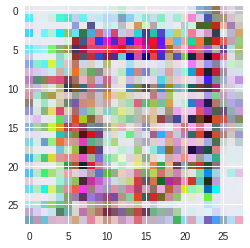

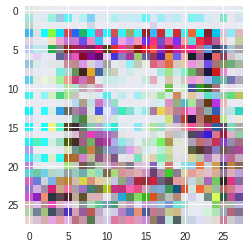

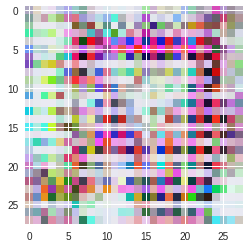

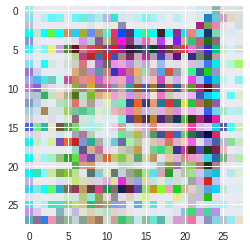

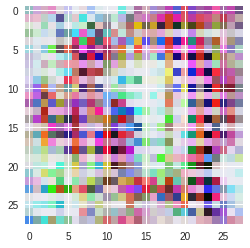

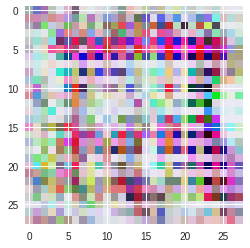

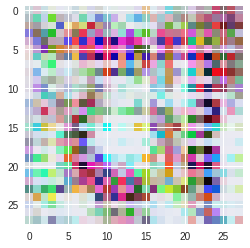

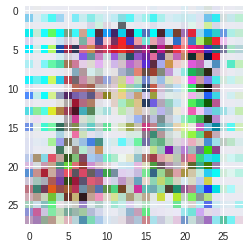

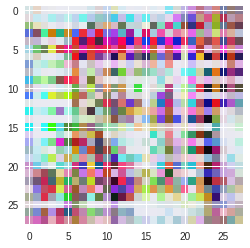

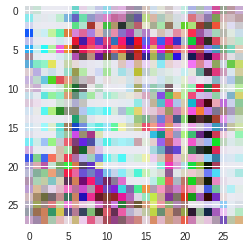

Epoch [8/50], Step [1/10], d_loss: 0.9154, g_loss: 5.3394, D(x): 0.92, D(G(z)): 0.30
Epoch [8/50], Step [2/10], d_loss: 0.9353, g_loss: 5.4398, D(x): 0.92, D(G(z)): 0.29
Epoch [8/50], Step [3/10], d_loss: 0.8129, g_loss: 5.6505, D(x): 0.92, D(G(z)): 0.27
Epoch [8/50], Step [4/10], d_loss: 0.7657, g_loss: 5.7171, D(x): 0.92, D(G(z)): 0.26
Epoch [8/50], Step [5/10], d_loss: 0.6348, g_loss: 5.8805, D(x): 0.94, D(G(z)): 0.23
Epoch [8/50], Step [6/10], d_loss: 0.5468, g_loss: 5.9271, D(x): 0.95, D(G(z)): 0.22
Epoch [8/50], Step [7/10], d_loss: 0.5414, g_loss: 5.8570, D(x): 0.96, D(G(z)): 0.23
Epoch [8/50], Step [8/10], d_loss: 0.4900, g_loss: 5.8414, D(x): 0.97, D(G(z)): 0.22
Epoch [8/50], Step [9/10], d_loss: 0.4911, g_loss: 5.7432, D(x): 0.98, D(G(z)): 0.23
Epoch [8/50], Step [10/10], d_loss: 0.5504, g_loss: 5.6171, D(x): 0.99, D(G(z)): 0.25


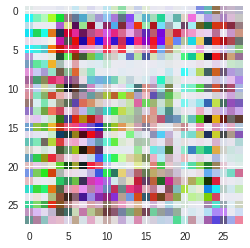

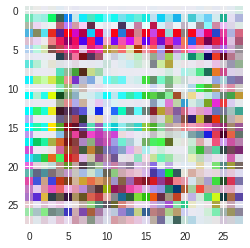

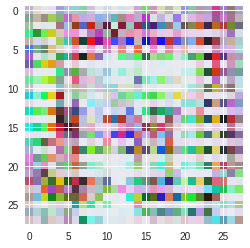

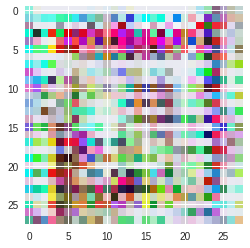

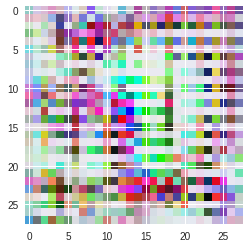

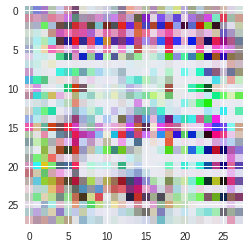

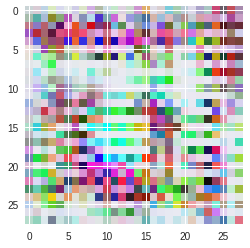

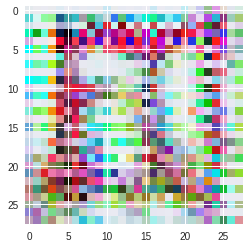

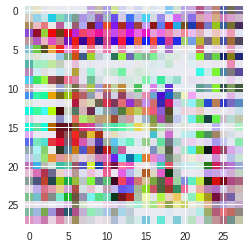

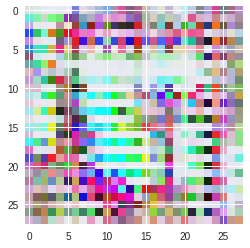

Epoch [9/50], Step [1/10], d_loss: 0.5749, g_loss: 5.4661, D(x): 0.99, D(G(z)): 0.27
Epoch [9/50], Step [2/10], d_loss: 0.6017, g_loss: 5.4294, D(x): 0.99, D(G(z)): 0.28
Epoch [9/50], Step [3/10], d_loss: 0.6660, g_loss: 5.3556, D(x): 0.99, D(G(z)): 0.30
Epoch [9/50], Step [4/10], d_loss: 0.6204, g_loss: 5.5456, D(x): 0.99, D(G(z)): 0.29
Epoch [9/50], Step [5/10], d_loss: 0.5768, g_loss: 5.7796, D(x): 0.99, D(G(z)): 0.27
Epoch [9/50], Step [6/10], d_loss: 0.5504, g_loss: 5.9311, D(x): 0.99, D(G(z)): 0.26
Epoch [9/50], Step [7/10], d_loss: 0.4820, g_loss: 6.1862, D(x): 0.99, D(G(z)): 0.23
Epoch [9/50], Step [8/10], d_loss: 0.4276, g_loss: 6.4327, D(x): 1.00, D(G(z)): 0.21
Epoch [9/50], Step [9/10], d_loss: 0.3830, g_loss: 6.6402, D(x): 1.00, D(G(z)): 0.19
Epoch [9/50], Step [10/10], d_loss: 0.3573, g_loss: 6.7833, D(x): 0.99, D(G(z)): 0.18


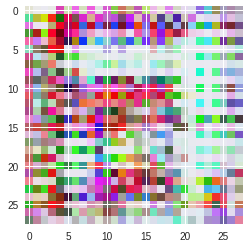

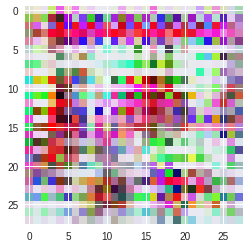

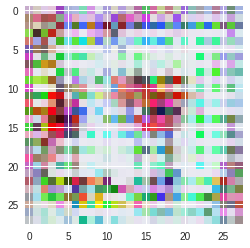

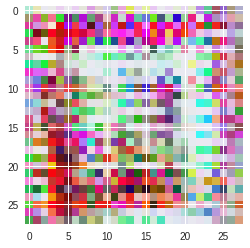

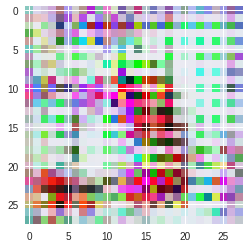

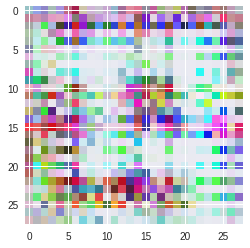

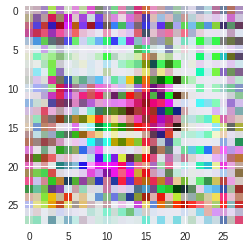

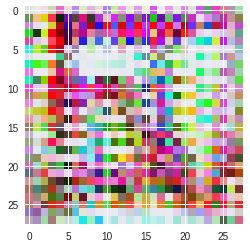

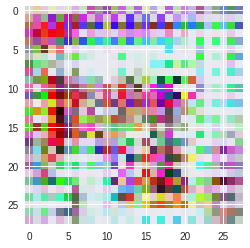

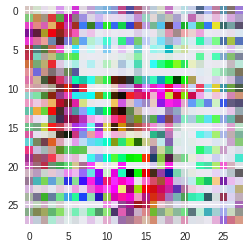

Epoch [10/50], Step [1/10], d_loss: 0.3307, g_loss: 6.9112, D(x): 1.00, D(G(z)): 0.17
Epoch [10/50], Step [2/10], d_loss: 0.3468, g_loss: 6.8158, D(x): 0.99, D(G(z)): 0.17
Epoch [10/50], Step [3/10], d_loss: 0.3362, g_loss: 6.7419, D(x): 1.00, D(G(z)): 0.17
Epoch [10/50], Step [4/10], d_loss: 0.3514, g_loss: 6.5908, D(x): 0.99, D(G(z)): 0.18
Epoch [10/50], Step [5/10], d_loss: 0.3728, g_loss: 6.4879, D(x): 0.99, D(G(z)): 0.19
Epoch [10/50], Step [6/10], d_loss: 0.3681, g_loss: 6.4437, D(x): 0.99, D(G(z)): 0.19
Epoch [10/50], Step [7/10], d_loss: 0.3574, g_loss: 6.3982, D(x): 0.99, D(G(z)): 0.19
Epoch [10/50], Step [8/10], d_loss: 0.3399, g_loss: 6.3767, D(x): 0.99, D(G(z)): 0.18
Epoch [10/50], Step [9/10], d_loss: 0.3119, g_loss: 6.4601, D(x): 0.99, D(G(z)): 0.17
Epoch [10/50], Step [10/10], d_loss: 0.2882, g_loss: 6.5796, D(x): 0.99, D(G(z)): 0.16


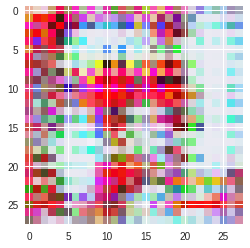

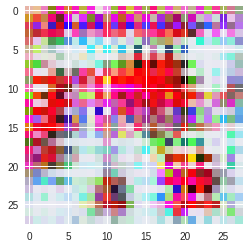

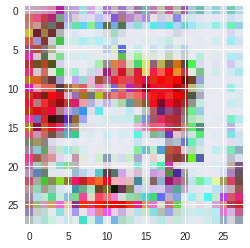

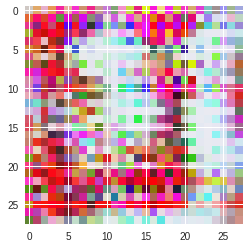

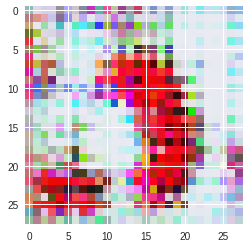

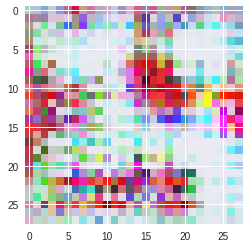

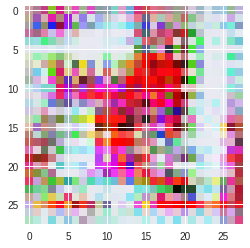

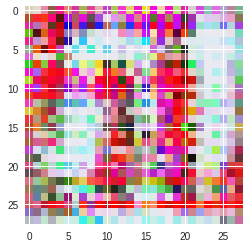

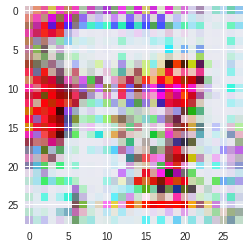

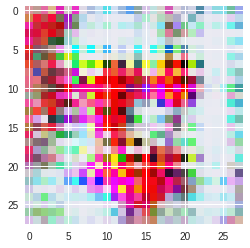

Epoch [11/50], Step [1/10], d_loss: 0.2801, g_loss: 6.7173, D(x): 0.99, D(G(z)): 0.15
Epoch [11/50], Step [2/10], d_loss: 0.2854, g_loss: 6.7783, D(x): 0.98, D(G(z)): 0.14
Epoch [11/50], Step [3/10], d_loss: 0.2842, g_loss: 6.8397, D(x): 0.97, D(G(z)): 0.13
Epoch [11/50], Step [4/10], d_loss: 0.2761, g_loss: 6.8546, D(x): 0.97, D(G(z)): 0.12
Epoch [11/50], Step [5/10], d_loss: 0.2816, g_loss: 6.8265, D(x): 0.96, D(G(z)): 0.12
Epoch [11/50], Step [6/10], d_loss: 0.2574, g_loss: 6.8003, D(x): 0.97, D(G(z)): 0.11
Epoch [11/50], Step [7/10], d_loss: 0.2754, g_loss: 6.7196, D(x): 0.97, D(G(z)): 0.12
Epoch [11/50], Step [8/10], d_loss: 0.2735, g_loss: 6.5929, D(x): 0.97, D(G(z)): 0.12
Epoch [11/50], Step [9/10], d_loss: 0.2844, g_loss: 6.3823, D(x): 0.98, D(G(z)): 0.13
Epoch [11/50], Step [10/10], d_loss: 0.2824, g_loss: 6.3621, D(x): 0.98, D(G(z)): 0.14


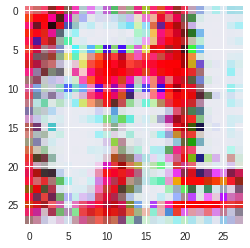

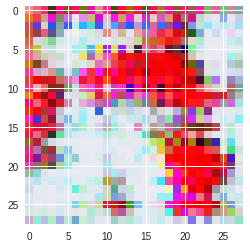

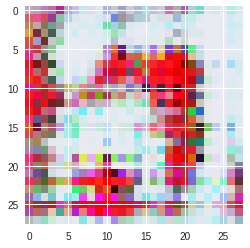

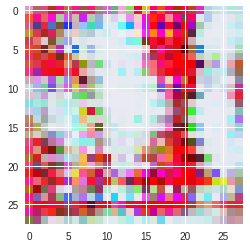

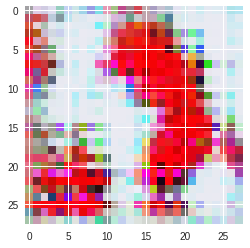

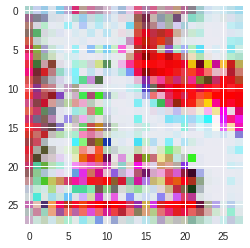

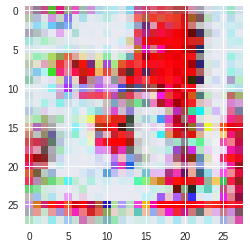

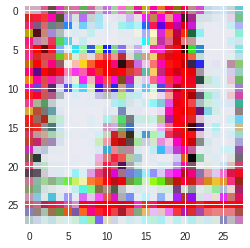

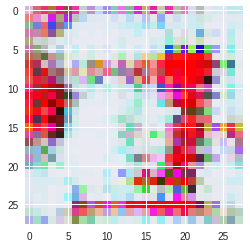

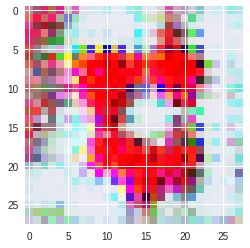

Epoch [12/50], Step [1/10], d_loss: 0.3207, g_loss: 6.2513, D(x): 0.98, D(G(z)): 0.15
Epoch [12/50], Step [2/10], d_loss: 0.3721, g_loss: 6.1384, D(x): 0.97, D(G(z)): 0.16
Epoch [12/50], Step [3/10], d_loss: 0.3565, g_loss: 6.0351, D(x): 0.97, D(G(z)): 0.16
Epoch [12/50], Step [4/10], d_loss: 0.3663, g_loss: 6.0097, D(x): 0.97, D(G(z)): 0.16
Epoch [12/50], Step [5/10], d_loss: 0.3437, g_loss: 5.9820, D(x): 0.98, D(G(z)): 0.16
Epoch [12/50], Step [6/10], d_loss: 0.3431, g_loss: 5.9720, D(x): 0.98, D(G(z)): 0.16
Epoch [12/50], Step [7/10], d_loss: 0.3175, g_loss: 5.9711, D(x): 0.98, D(G(z)): 0.16
Epoch [12/50], Step [8/10], d_loss: 0.2970, g_loss: 5.9490, D(x): 0.99, D(G(z)): 0.15
Epoch [12/50], Step [9/10], d_loss: 0.2800, g_loss: 6.0104, D(x): 0.99, D(G(z)): 0.15
Epoch [12/50], Step [10/10], d_loss: 0.2662, g_loss: 6.0220, D(x): 0.99, D(G(z)): 0.14


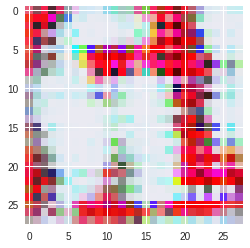

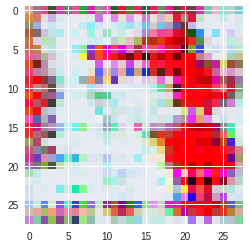

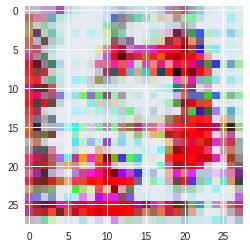

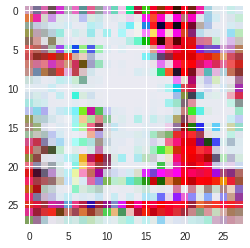

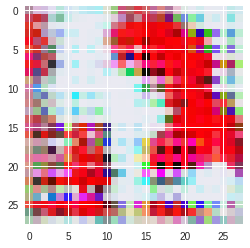

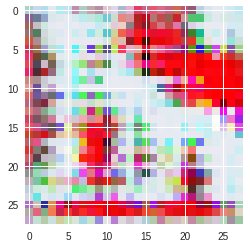

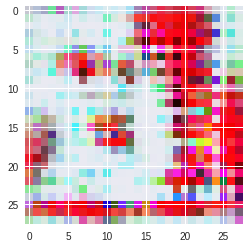

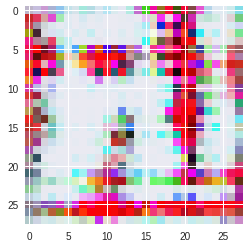

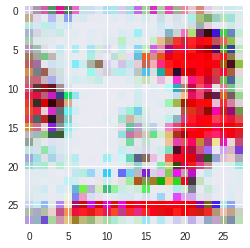

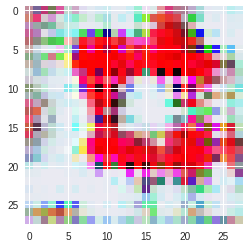

Epoch [13/50], Step [1/10], d_loss: 0.2533, g_loss: 6.0402, D(x): 0.99, D(G(z)): 0.13
Epoch [13/50], Step [2/10], d_loss: 0.2396, g_loss: 6.1193, D(x): 0.99, D(G(z)): 0.12
Epoch [13/50], Step [3/10], d_loss: 0.2139, g_loss: 6.1781, D(x): 0.99, D(G(z)): 0.12
Epoch [13/50], Step [4/10], d_loss: 0.2097, g_loss: 6.2116, D(x): 0.99, D(G(z)): 0.11
Epoch [13/50], Step [5/10], d_loss: 0.1769, g_loss: 6.2708, D(x): 0.99, D(G(z)): 0.10
Epoch [13/50], Step [6/10], d_loss: 0.1572, g_loss: 6.3264, D(x): 0.99, D(G(z)): 0.09
Epoch [13/50], Step [7/10], d_loss: 0.1559, g_loss: 6.2855, D(x): 0.99, D(G(z)): 0.09
Epoch [13/50], Step [8/10], d_loss: 0.1266, g_loss: 6.3231, D(x): 1.00, D(G(z)): 0.08
Epoch [13/50], Step [9/10], d_loss: 0.1349, g_loss: 6.1627, D(x): 1.00, D(G(z)): 0.09
Epoch [13/50], Step [10/10], d_loss: 0.1215, g_loss: 6.1730, D(x): 1.00, D(G(z)): 0.08


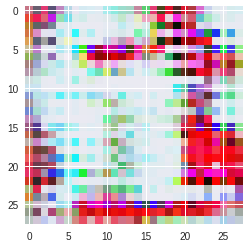

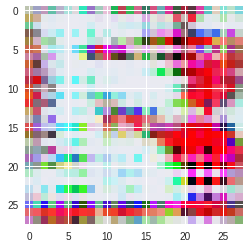

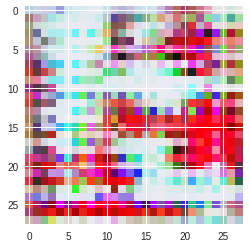

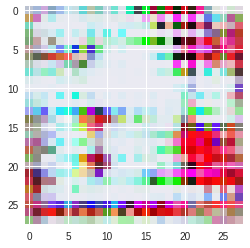

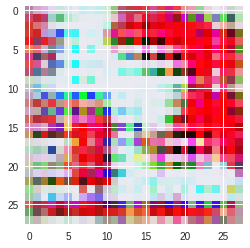

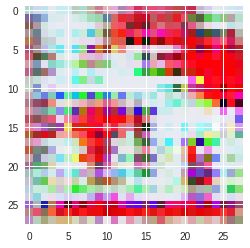

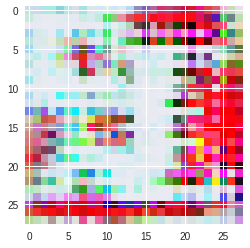

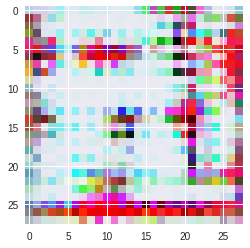

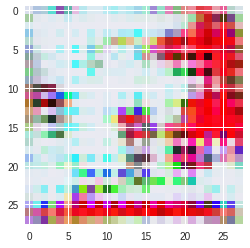

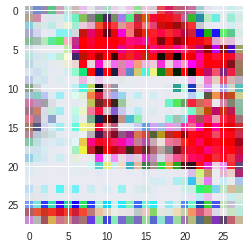

Epoch [14/50], Step [1/10], d_loss: 0.1194, g_loss: 6.2010, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [2/10], d_loss: 0.1295, g_loss: 6.0690, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [3/10], d_loss: 0.1200, g_loss: 6.0092, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [4/10], d_loss: 0.1168, g_loss: 6.0483, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [5/10], d_loss: 0.1236, g_loss: 6.0387, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [6/10], d_loss: 0.1183, g_loss: 6.0103, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [7/10], d_loss: 0.1276, g_loss: 5.9258, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [8/10], d_loss: 0.1236, g_loss: 5.9297, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [9/10], d_loss: 0.1249, g_loss: 5.9661, D(x): 1.00, D(G(z)): 0.08
Epoch [14/50], Step [10/10], d_loss: 0.1326, g_loss: 5.9057, D(x): 1.00, D(G(z)): 0.09


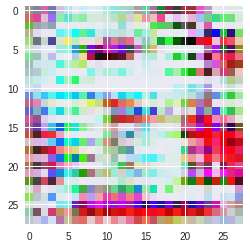

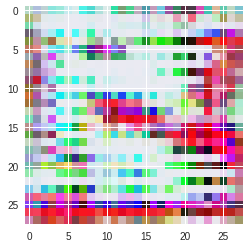

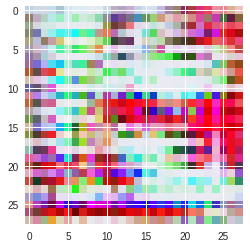

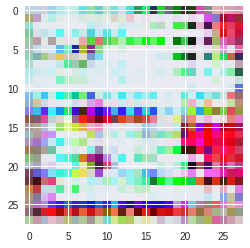

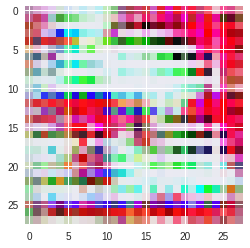

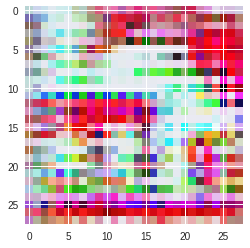

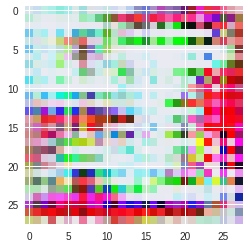

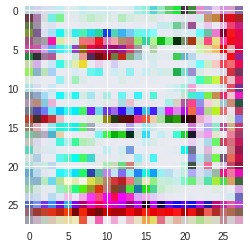

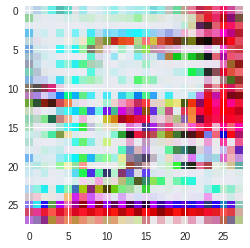

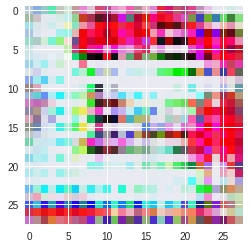

Epoch [15/50], Step [1/10], d_loss: 0.1403, g_loss: 5.9049, D(x): 1.00, D(G(z)): 0.09
Epoch [15/50], Step [2/10], d_loss: 0.1285, g_loss: 5.8989, D(x): 1.00, D(G(z)): 0.09
Epoch [15/50], Step [3/10], d_loss: 0.1199, g_loss: 5.9440, D(x): 1.00, D(G(z)): 0.08
Epoch [15/50], Step [4/10], d_loss: 0.1252, g_loss: 5.9334, D(x): 1.00, D(G(z)): 0.08
Epoch [15/50], Step [5/10], d_loss: 0.1234, g_loss: 5.9193, D(x): 1.00, D(G(z)): 0.08
Epoch [15/50], Step [6/10], d_loss: 0.1267, g_loss: 5.9224, D(x): 1.00, D(G(z)): 0.08
Epoch [15/50], Step [7/10], d_loss: 0.1091, g_loss: 5.9409, D(x): 1.00, D(G(z)): 0.08
Epoch [15/50], Step [8/10], d_loss: 0.1001, g_loss: 5.9412, D(x): 1.00, D(G(z)): 0.07
Epoch [15/50], Step [9/10], d_loss: 0.1035, g_loss: 5.8894, D(x): 1.00, D(G(z)): 0.07
Epoch [15/50], Step [10/10], d_loss: 0.1033, g_loss: 5.8693, D(x): 1.00, D(G(z)): 0.07


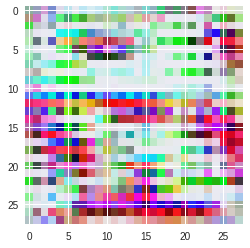

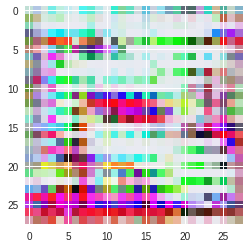

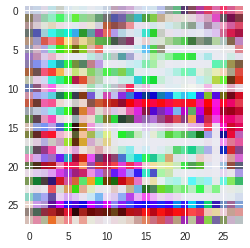

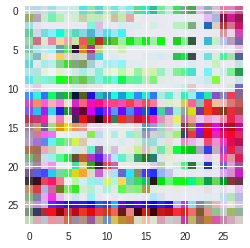

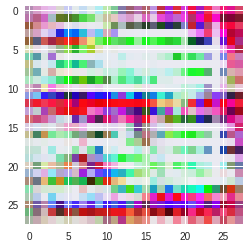

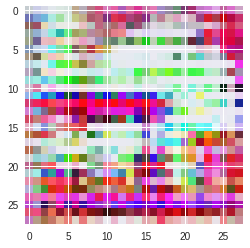

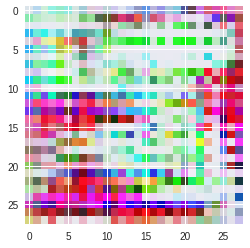

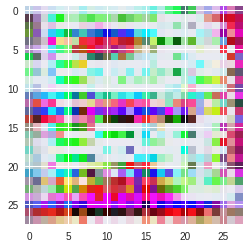

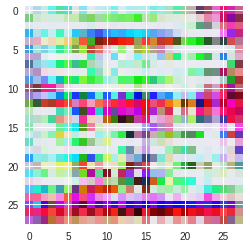

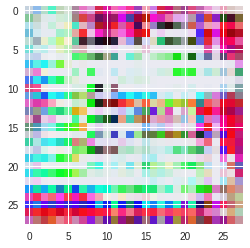

Epoch [16/50], Step [1/10], d_loss: 0.1027, g_loss: 5.8699, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [2/10], d_loss: 0.1061, g_loss: 5.8240, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [3/10], d_loss: 0.1078, g_loss: 5.8389, D(x): 1.00, D(G(z)): 0.08
Epoch [16/50], Step [4/10], d_loss: 0.1010, g_loss: 5.8145, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [5/10], d_loss: 0.1041, g_loss: 5.8252, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [6/10], d_loss: 0.1046, g_loss: 5.8883, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [7/10], d_loss: 0.1035, g_loss: 5.9329, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [8/10], d_loss: 0.1003, g_loss: 6.0592, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [9/10], d_loss: 0.1025, g_loss: 6.0813, D(x): 1.00, D(G(z)): 0.07
Epoch [16/50], Step [10/10], d_loss: 0.1084, g_loss: 6.1099, D(x): 1.00, D(G(z)): 0.07


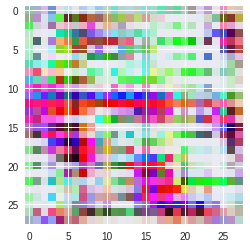

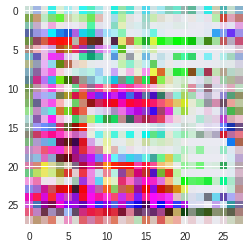

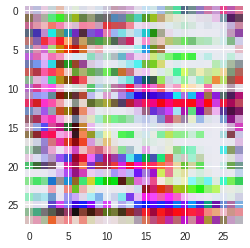

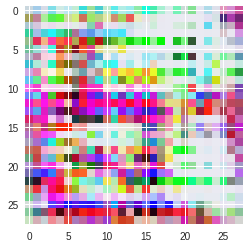

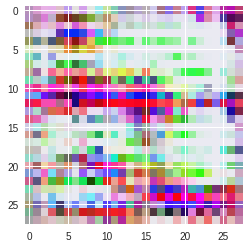

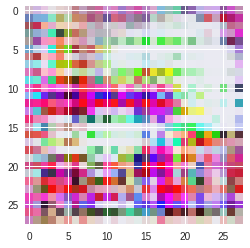

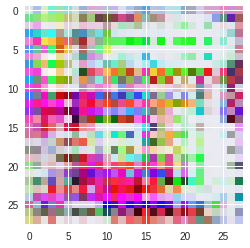

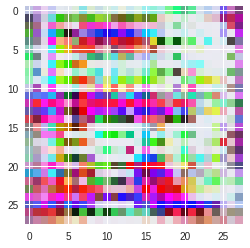

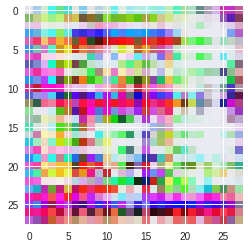

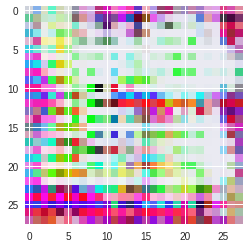

Epoch [17/50], Step [1/10], d_loss: 0.0945, g_loss: 6.3220, D(x): 1.00, D(G(z)): 0.07
Epoch [17/50], Step [2/10], d_loss: 0.1117, g_loss: 6.2813, D(x): 1.00, D(G(z)): 0.07
Epoch [17/50], Step [3/10], d_loss: 0.1027, g_loss: 6.2680, D(x): 1.00, D(G(z)): 0.07
Epoch [17/50], Step [4/10], d_loss: 0.1226, g_loss: 6.3516, D(x): 1.00, D(G(z)): 0.08
Epoch [17/50], Step [5/10], d_loss: 0.1243, g_loss: 6.3437, D(x): 1.00, D(G(z)): 0.08
Epoch [17/50], Step [6/10], d_loss: 0.1450, g_loss: 6.3502, D(x): 1.00, D(G(z)): 0.09
Epoch [17/50], Step [7/10], d_loss: 0.1563, g_loss: 6.4146, D(x): 1.00, D(G(z)): 0.09
Epoch [17/50], Step [8/10], d_loss: 0.1482, g_loss: 6.4886, D(x): 1.00, D(G(z)): 0.09
Epoch [17/50], Step [9/10], d_loss: 0.1564, g_loss: 6.5297, D(x): 1.00, D(G(z)): 0.09
Epoch [17/50], Step [10/10], d_loss: 0.1509, g_loss: 6.6602, D(x): 1.00, D(G(z)): 0.09


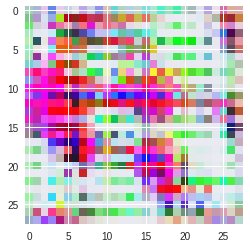

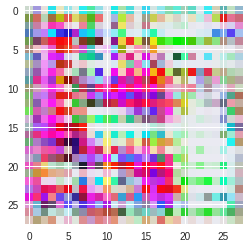

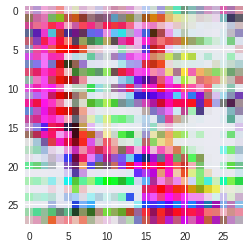

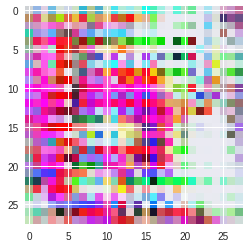

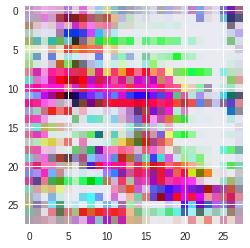

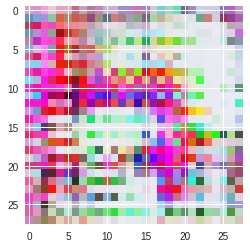

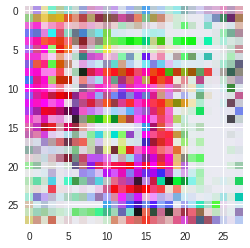

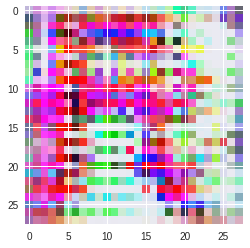

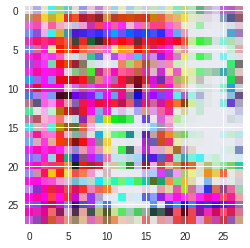

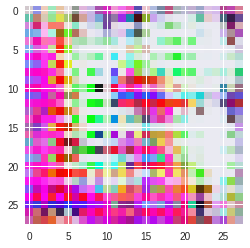

Epoch [18/50], Step [1/10], d_loss: 0.1342, g_loss: 6.8068, D(x): 1.00, D(G(z)): 0.08
Epoch [18/50], Step [2/10], d_loss: 0.1210, g_loss: 6.9974, D(x): 1.00, D(G(z)): 0.07
Epoch [18/50], Step [3/10], d_loss: 0.0948, g_loss: 7.1300, D(x): 1.00, D(G(z)): 0.06
Epoch [18/50], Step [4/10], d_loss: 0.0805, g_loss: 7.2970, D(x): 1.00, D(G(z)): 0.05
Epoch [18/50], Step [5/10], d_loss: 0.0580, g_loss: 7.4023, D(x): 1.00, D(G(z)): 0.04
Epoch [18/50], Step [6/10], d_loss: 0.0490, g_loss: 7.5047, D(x): 1.00, D(G(z)): 0.03
Epoch [18/50], Step [7/10], d_loss: 0.0383, g_loss: 7.6573, D(x): 1.00, D(G(z)): 0.03
Epoch [18/50], Step [8/10], d_loss: 0.0347, g_loss: 7.6777, D(x): 1.00, D(G(z)): 0.03
Epoch [18/50], Step [9/10], d_loss: 0.0341, g_loss: 7.6441, D(x): 1.00, D(G(z)): 0.02
Epoch [18/50], Step [10/10], d_loss: 0.0282, g_loss: 7.6317, D(x): 1.00, D(G(z)): 0.02


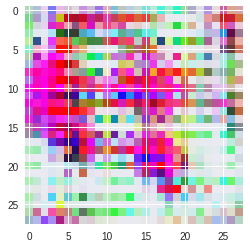

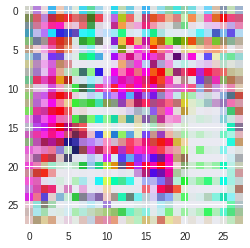

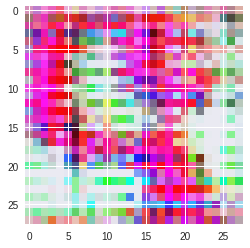

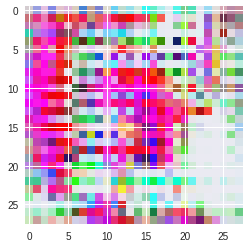

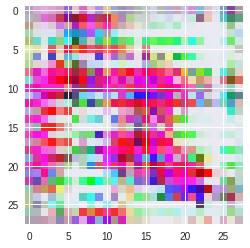

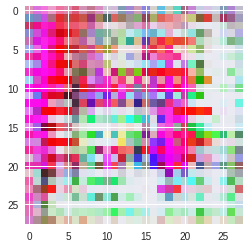

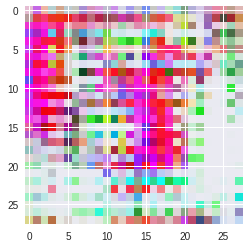

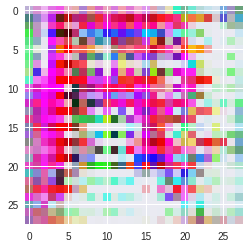

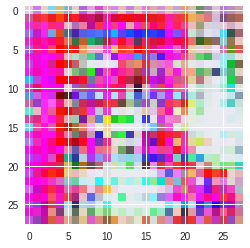

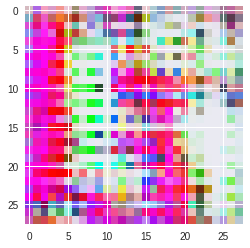

Epoch [19/50], Step [1/10], d_loss: 0.0277, g_loss: 7.4892, D(x): 1.00, D(G(z)): 0.02
Epoch [19/50], Step [2/10], d_loss: 0.0364, g_loss: 7.3682, D(x): 1.00, D(G(z)): 0.03
Epoch [19/50], Step [3/10], d_loss: 0.0365, g_loss: 7.2350, D(x): 1.00, D(G(z)): 0.03
Epoch [19/50], Step [4/10], d_loss: 0.0468, g_loss: 7.0184, D(x): 1.00, D(G(z)): 0.03
Epoch [19/50], Step [5/10], d_loss: 0.0511, g_loss: 6.8433, D(x): 1.00, D(G(z)): 0.04
Epoch [19/50], Step [6/10], d_loss: 0.0677, g_loss: 6.6172, D(x): 1.00, D(G(z)): 0.05
Epoch [19/50], Step [7/10], d_loss: 0.0786, g_loss: 6.4672, D(x): 1.00, D(G(z)): 0.05
Epoch [19/50], Step [8/10], d_loss: 0.0813, g_loss: 6.4296, D(x): 1.00, D(G(z)): 0.06
Epoch [19/50], Step [9/10], d_loss: 0.1000, g_loss: 6.3836, D(x): 1.00, D(G(z)): 0.07
Epoch [19/50], Step [10/10], d_loss: 0.0999, g_loss: 6.4663, D(x): 1.00, D(G(z)): 0.07


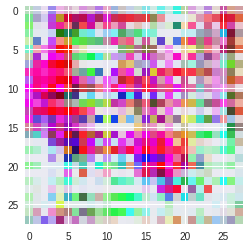

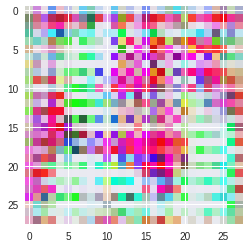

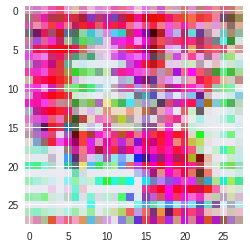

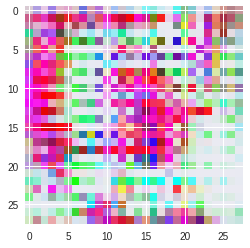

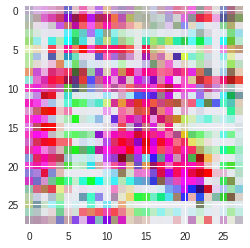

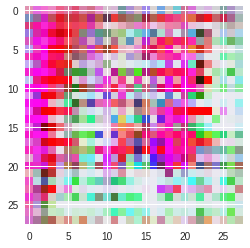

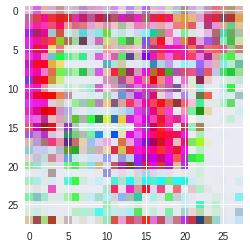

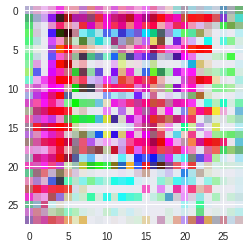

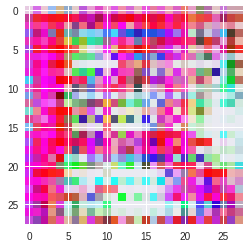

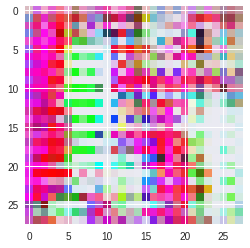

Epoch [20/50], Step [1/10], d_loss: 0.1136, g_loss: 6.4770, D(x): 1.00, D(G(z)): 0.07
Epoch [20/50], Step [2/10], d_loss: 0.1095, g_loss: 6.7380, D(x): 1.00, D(G(z)): 0.07
Epoch [20/50], Step [3/10], d_loss: 0.1131, g_loss: 6.8724, D(x): 1.00, D(G(z)): 0.07
Epoch [20/50], Step [4/10], d_loss: 0.1048, g_loss: 7.0344, D(x): 1.00, D(G(z)): 0.06
Epoch [20/50], Step [5/10], d_loss: 0.0927, g_loss: 7.2787, D(x): 1.00, D(G(z)): 0.06
Epoch [20/50], Step [6/10], d_loss: 0.0968, g_loss: 7.3742, D(x): 1.00, D(G(z)): 0.06
Epoch [20/50], Step [7/10], d_loss: 0.0937, g_loss: 7.6067, D(x): 1.00, D(G(z)): 0.05
Epoch [20/50], Step [8/10], d_loss: 0.0906, g_loss: 7.7009, D(x): 1.00, D(G(z)): 0.05
Epoch [20/50], Step [9/10], d_loss: 0.0876, g_loss: 7.7553, D(x): 1.00, D(G(z)): 0.05
Epoch [20/50], Step [10/10], d_loss: 0.1270, g_loss: 7.7522, D(x): 1.00, D(G(z)): 0.06


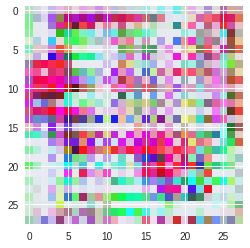

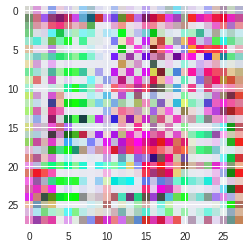

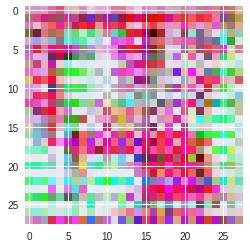

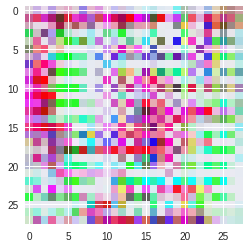

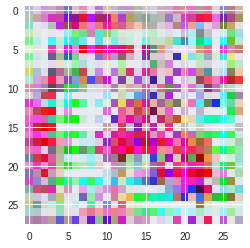

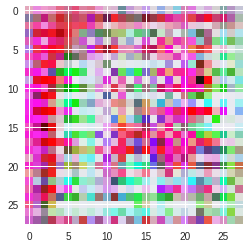

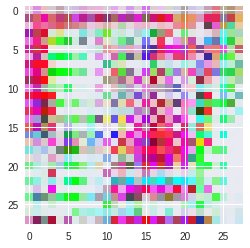

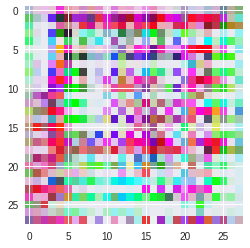

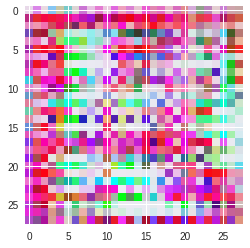

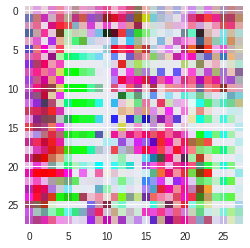

Epoch [21/50], Step [1/10], d_loss: 0.1239, g_loss: 7.8063, D(x): 1.00, D(G(z)): 0.06
Epoch [21/50], Step [2/10], d_loss: 0.1435, g_loss: 7.7620, D(x): 1.00, D(G(z)): 0.07
Epoch [21/50], Step [3/10], d_loss: 0.1624, g_loss: 7.7210, D(x): 1.00, D(G(z)): 0.08
Epoch [21/50], Step [4/10], d_loss: 0.1757, g_loss: 7.7602, D(x): 0.99, D(G(z)): 0.08
Epoch [21/50], Step [5/10], d_loss: 0.2223, g_loss: 7.6492, D(x): 0.99, D(G(z)): 0.10
Epoch [21/50], Step [6/10], d_loss: 0.2487, g_loss: 7.7369, D(x): 1.00, D(G(z)): 0.10
Epoch [21/50], Step [7/10], d_loss: 0.2731, g_loss: 7.8145, D(x): 1.00, D(G(z)): 0.11
Epoch [21/50], Step [8/10], d_loss: 0.2605, g_loss: 7.9882, D(x): 1.00, D(G(z)): 0.11
Epoch [21/50], Step [9/10], d_loss: 0.3157, g_loss: 8.0331, D(x): 1.00, D(G(z)): 0.12
Epoch [21/50], Step [10/10], d_loss: 0.3110, g_loss: 8.2727, D(x): 0.99, D(G(z)): 0.12


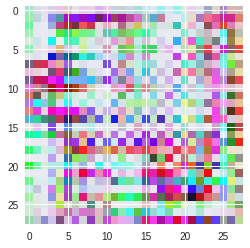

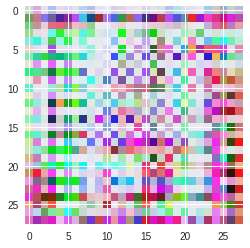

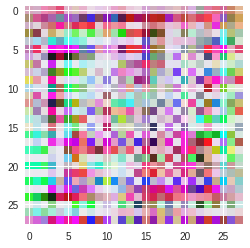

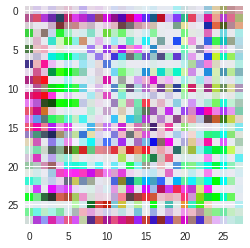

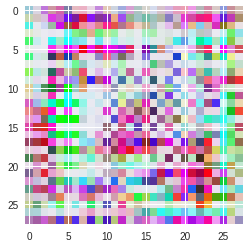

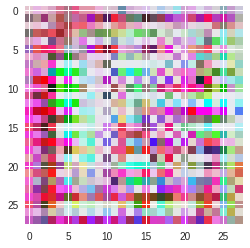

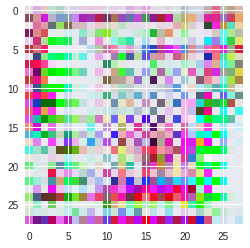

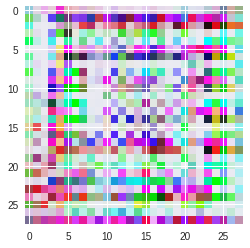

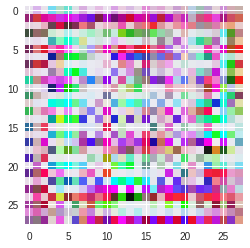

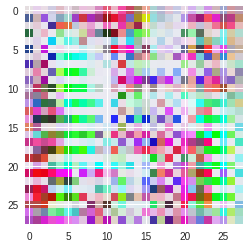

Epoch [22/50], Step [1/10], d_loss: 0.3197, g_loss: 8.4300, D(x): 1.00, D(G(z)): 0.12
Epoch [22/50], Step [2/10], d_loss: 0.3201, g_loss: 8.6726, D(x): 0.99, D(G(z)): 0.12
Epoch [22/50], Step [3/10], d_loss: 0.2838, g_loss: 8.8697, D(x): 0.99, D(G(z)): 0.11
Epoch [22/50], Step [4/10], d_loss: 0.2970, g_loss: 8.9231, D(x): 0.99, D(G(z)): 0.11
Epoch [22/50], Step [5/10], d_loss: 0.2150, g_loss: 9.4104, D(x): 0.99, D(G(z)): 0.09
Epoch [22/50], Step [6/10], d_loss: 0.1721, g_loss: 9.7650, D(x): 1.00, D(G(z)): 0.07
Epoch [22/50], Step [7/10], d_loss: 0.1323, g_loss: 9.9482, D(x): 1.00, D(G(z)): 0.06
Epoch [22/50], Step [8/10], d_loss: 0.0979, g_loss: 10.2502, D(x): 1.00, D(G(z)): 0.05
Epoch [22/50], Step [9/10], d_loss: 0.0728, g_loss: 10.3052, D(x): 1.00, D(G(z)): 0.04
Epoch [22/50], Step [10/10], d_loss: 0.0661, g_loss: 10.1624, D(x): 0.99, D(G(z)): 0.03


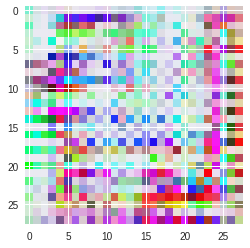

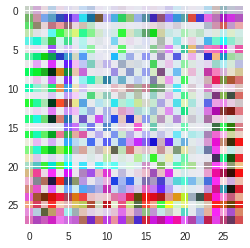

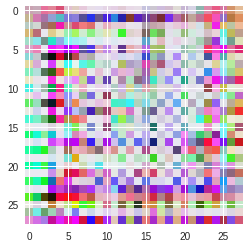

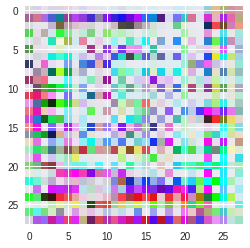

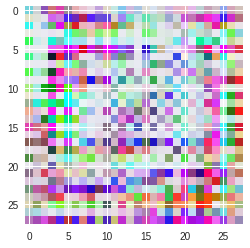

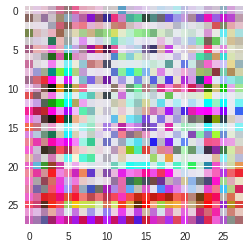

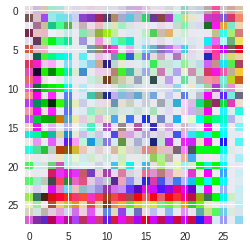

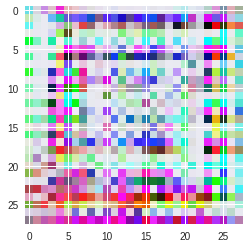

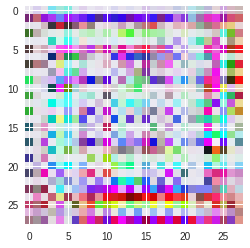

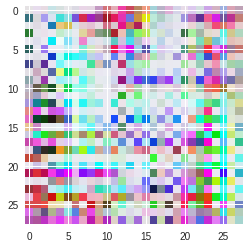

Epoch [23/50], Step [1/10], d_loss: 0.0597, g_loss: 10.0191, D(x): 1.00, D(G(z)): 0.03
Epoch [23/50], Step [2/10], d_loss: 0.0506, g_loss: 9.7156, D(x): 0.99, D(G(z)): 0.03
Epoch [23/50], Step [3/10], d_loss: 0.0500, g_loss: 9.3260, D(x): 0.99, D(G(z)): 0.03
Epoch [23/50], Step [4/10], d_loss: 0.0668, g_loss: 8.8756, D(x): 0.99, D(G(z)): 0.03
Epoch [23/50], Step [5/10], d_loss: 0.0745, g_loss: 8.3951, D(x): 0.99, D(G(z)): 0.04
Epoch [23/50], Step [6/10], d_loss: 0.0763, g_loss: 8.0363, D(x): 0.99, D(G(z)): 0.04
Epoch [23/50], Step [7/10], d_loss: 0.0919, g_loss: 7.6436, D(x): 1.00, D(G(z)): 0.05
Epoch [23/50], Step [8/10], d_loss: 0.1095, g_loss: 7.4095, D(x): 1.00, D(G(z)): 0.06
Epoch [23/50], Step [9/10], d_loss: 0.1215, g_loss: 7.3718, D(x): 1.00, D(G(z)): 0.06
Epoch [23/50], Step [10/10], d_loss: 0.1309, g_loss: 7.4692, D(x): 0.99, D(G(z)): 0.06


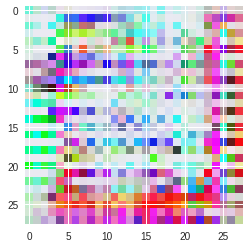

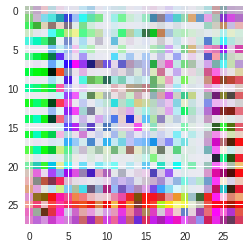

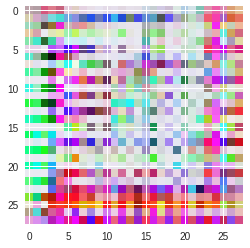

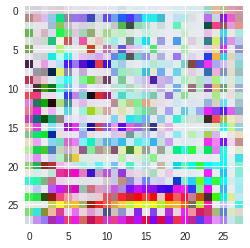

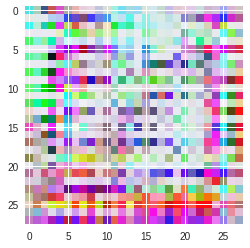

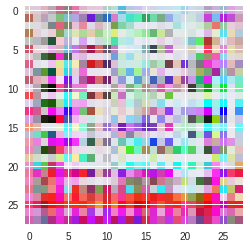

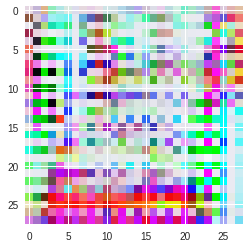

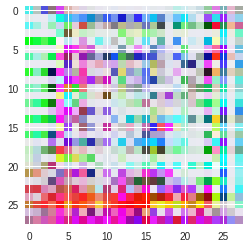

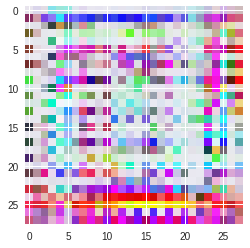

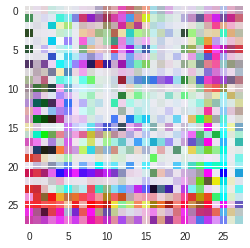

Epoch [24/50], Step [1/10], d_loss: 0.0856, g_loss: 7.7371, D(x): 1.00, D(G(z)): 0.05
Epoch [24/50], Step [2/10], d_loss: 0.0827, g_loss: 7.9419, D(x): 0.99, D(G(z)): 0.04
Epoch [24/50], Step [3/10], d_loss: 0.0612, g_loss: 8.1880, D(x): 1.00, D(G(z)): 0.03
Epoch [24/50], Step [4/10], d_loss: 0.0481, g_loss: 8.4809, D(x): 0.99, D(G(z)): 0.03
Epoch [24/50], Step [5/10], d_loss: 0.0387, g_loss: 8.6729, D(x): 0.99, D(G(z)): 0.02
Epoch [24/50], Step [6/10], d_loss: 0.0327, g_loss: 8.7184, D(x): 1.00, D(G(z)): 0.02
Epoch [24/50], Step [7/10], d_loss: 0.0300, g_loss: 8.7772, D(x): 1.00, D(G(z)): 0.02
Epoch [24/50], Step [8/10], d_loss: 0.0290, g_loss: 8.7184, D(x): 1.00, D(G(z)): 0.01
Epoch [24/50], Step [9/10], d_loss: 0.0255, g_loss: 8.5077, D(x): 1.00, D(G(z)): 0.02
Epoch [24/50], Step [10/10], d_loss: 0.0390, g_loss: 8.3905, D(x): 0.99, D(G(z)): 0.02


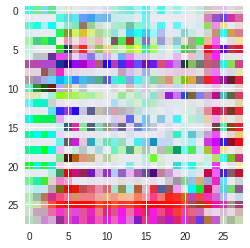

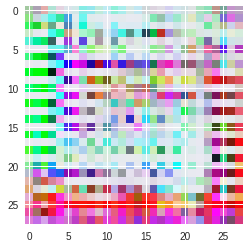

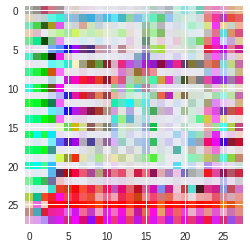

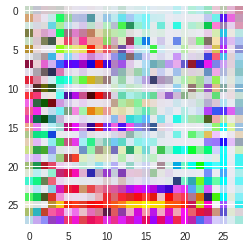

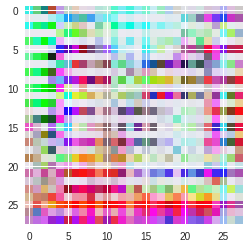

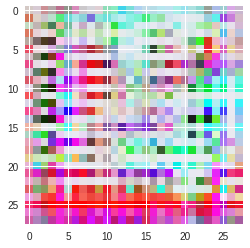

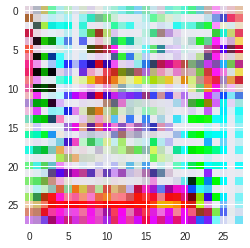

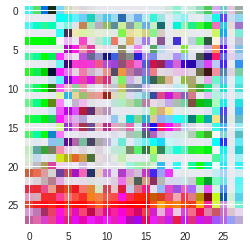

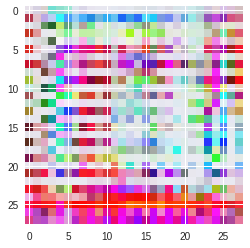

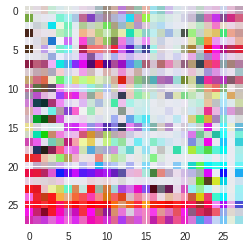

Epoch [25/50], Step [1/10], d_loss: 0.0282, g_loss: 8.1606, D(x): 1.00, D(G(z)): 0.02
Epoch [25/50], Step [2/10], d_loss: 0.0465, g_loss: 7.8636, D(x): 0.99, D(G(z)): 0.03
Epoch [25/50], Step [3/10], d_loss: 0.0491, g_loss: 7.6608, D(x): 1.00, D(G(z)): 0.03
Epoch [25/50], Step [4/10], d_loss: 0.0561, g_loss: 7.4143, D(x): 1.00, D(G(z)): 0.04
Epoch [25/50], Step [5/10], d_loss: 0.0734, g_loss: 7.2769, D(x): 1.00, D(G(z)): 0.04
Epoch [25/50], Step [6/10], d_loss: 0.0836, g_loss: 7.1269, D(x): 1.00, D(G(z)): 0.05
Epoch [25/50], Step [7/10], d_loss: 0.0968, g_loss: 7.1672, D(x): 1.00, D(G(z)): 0.06
Epoch [25/50], Step [8/10], d_loss: 0.1077, g_loss: 7.2481, D(x): 1.00, D(G(z)): 0.06
Epoch [25/50], Step [9/10], d_loss: 0.0896, g_loss: 7.3716, D(x): 1.00, D(G(z)): 0.06
Epoch [25/50], Step [10/10], d_loss: 0.1019, g_loss: 7.4288, D(x): 1.00, D(G(z)): 0.06


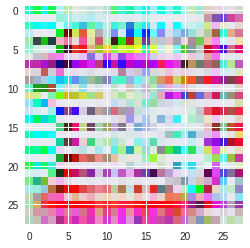

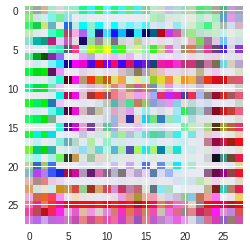

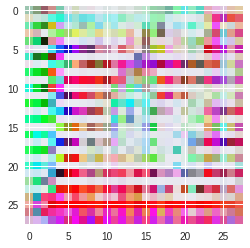

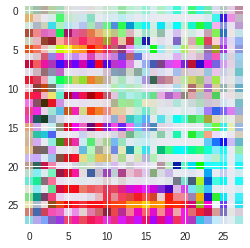

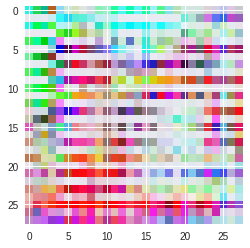

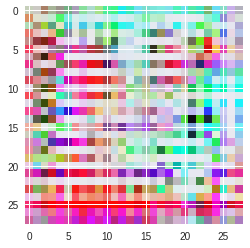

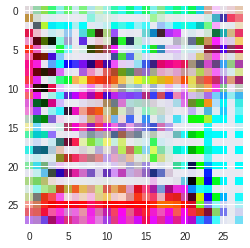

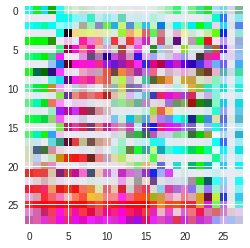

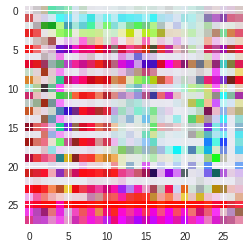

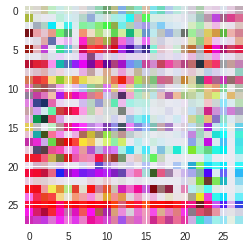

Epoch [26/50], Step [1/10], d_loss: 0.0965, g_loss: 7.5600, D(x): 1.00, D(G(z)): 0.06
Epoch [26/50], Step [2/10], d_loss: 0.0977, g_loss: 7.6868, D(x): 1.00, D(G(z)): 0.06
Epoch [26/50], Step [3/10], d_loss: 0.1019, g_loss: 7.7573, D(x): 1.00, D(G(z)): 0.06
Epoch [26/50], Step [4/10], d_loss: 0.1029, g_loss: 7.6972, D(x): 1.00, D(G(z)): 0.06
Epoch [26/50], Step [5/10], d_loss: 0.1267, g_loss: 7.6632, D(x): 0.99, D(G(z)): 0.07
Epoch [26/50], Step [6/10], d_loss: 0.1261, g_loss: 7.6753, D(x): 1.00, D(G(z)): 0.07
Epoch [26/50], Step [7/10], d_loss: 0.1495, g_loss: 7.5568, D(x): 1.00, D(G(z)): 0.08
Epoch [26/50], Step [8/10], d_loss: 0.1580, g_loss: 7.4206, D(x): 0.99, D(G(z)): 0.09
Epoch [26/50], Step [9/10], d_loss: 0.1582, g_loss: 7.4236, D(x): 0.99, D(G(z)): 0.09
Epoch [26/50], Step [10/10], d_loss: 0.1680, g_loss: 7.3690, D(x): 0.99, D(G(z)): 0.10


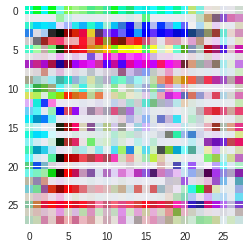

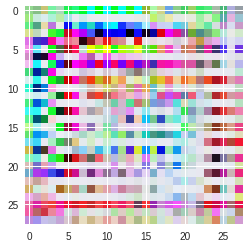

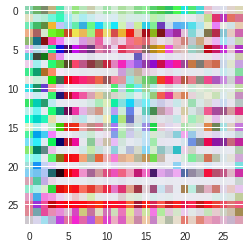

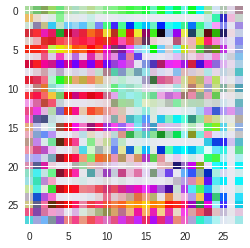

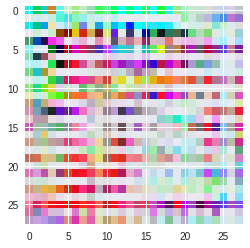

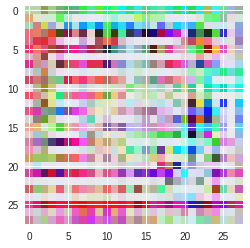

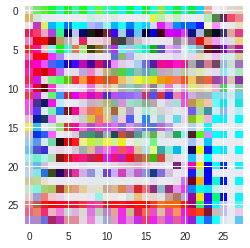

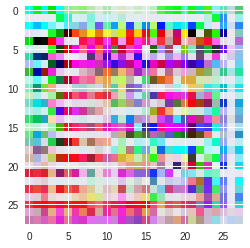

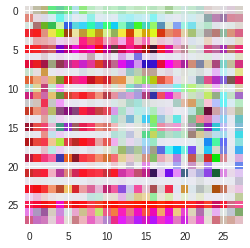

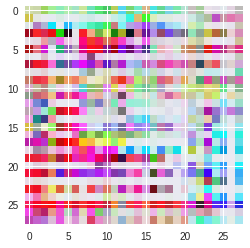

Epoch [27/50], Step [1/10], d_loss: 0.1496, g_loss: 7.3824, D(x): 1.00, D(G(z)): 0.09
Epoch [27/50], Step [2/10], d_loss: 0.1483, g_loss: 7.3579, D(x): 0.99, D(G(z)): 0.09
Epoch [27/50], Step [3/10], d_loss: 0.1348, g_loss: 7.3092, D(x): 0.99, D(G(z)): 0.08
Epoch [27/50], Step [4/10], d_loss: 0.1439, g_loss: 7.2051, D(x): 0.99, D(G(z)): 0.09
Epoch [27/50], Step [5/10], d_loss: 0.1307, g_loss: 7.2577, D(x): 0.99, D(G(z)): 0.08
Epoch [27/50], Step [6/10], d_loss: 0.1214, g_loss: 7.2524, D(x): 0.99, D(G(z)): 0.07
Epoch [27/50], Step [7/10], d_loss: 0.1227, g_loss: 7.1572, D(x): 0.99, D(G(z)): 0.08
Epoch [27/50], Step [8/10], d_loss: 0.1137, g_loss: 7.2223, D(x): 0.99, D(G(z)): 0.07
Epoch [27/50], Step [9/10], d_loss: 0.1274, g_loss: 7.2118, D(x): 0.99, D(G(z)): 0.07
Epoch [27/50], Step [10/10], d_loss: 0.1101, g_loss: 7.2579, D(x): 1.00, D(G(z)): 0.07


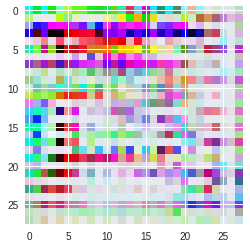

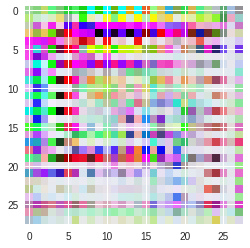

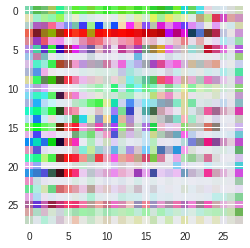

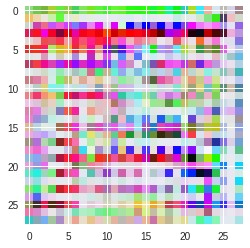

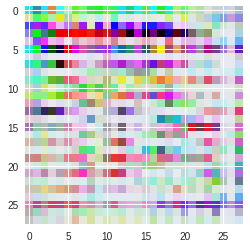

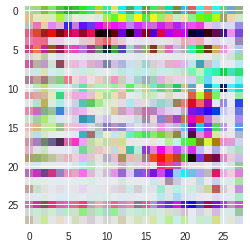

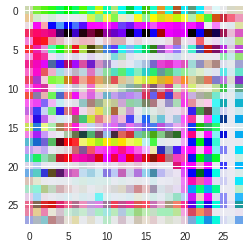

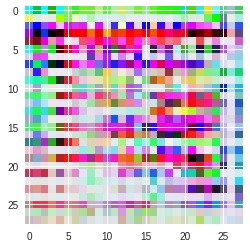

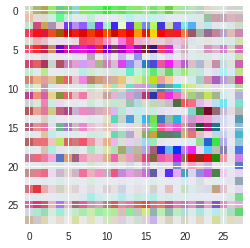

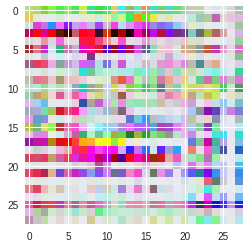

Epoch [28/50], Step [1/10], d_loss: 0.1010, g_loss: 7.3537, D(x): 1.00, D(G(z)): 0.07
Epoch [28/50], Step [2/10], d_loss: 0.1013, g_loss: 7.4298, D(x): 1.00, D(G(z)): 0.06
Epoch [28/50], Step [3/10], d_loss: 0.1045, g_loss: 7.5462, D(x): 1.00, D(G(z)): 0.07
Epoch [28/50], Step [4/10], d_loss: 0.1039, g_loss: 7.6884, D(x): 0.99, D(G(z)): 0.06
Epoch [28/50], Step [5/10], d_loss: 0.1101, g_loss: 7.7835, D(x): 0.99, D(G(z)): 0.06
Epoch [28/50], Step [6/10], d_loss: 0.1253, g_loss: 7.9208, D(x): 0.99, D(G(z)): 0.07
Epoch [28/50], Step [7/10], d_loss: 0.1085, g_loss: 8.0792, D(x): 1.00, D(G(z)): 0.06
Epoch [28/50], Step [8/10], d_loss: 0.0895, g_loss: 8.2895, D(x): 1.00, D(G(z)): 0.05
Epoch [28/50], Step [9/10], d_loss: 0.1128, g_loss: 8.2970, D(x): 1.00, D(G(z)): 0.06
Epoch [28/50], Step [10/10], d_loss: 0.1082, g_loss: 8.4845, D(x): 1.00, D(G(z)): 0.06


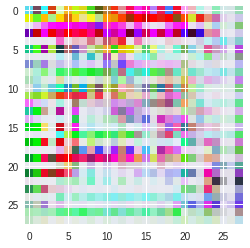

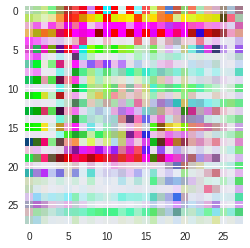

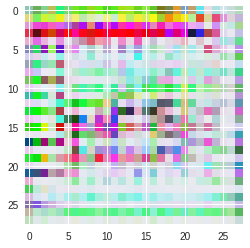

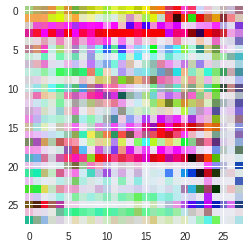

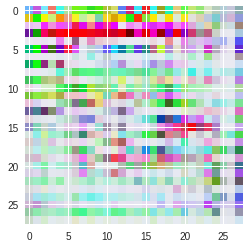

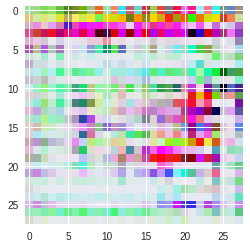

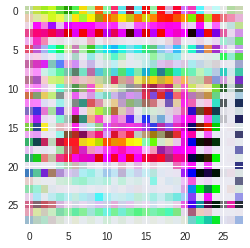

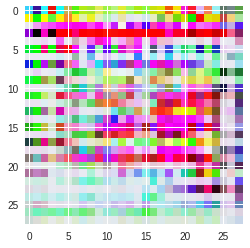

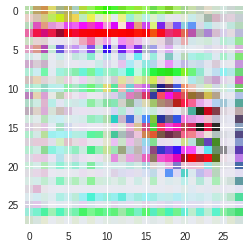

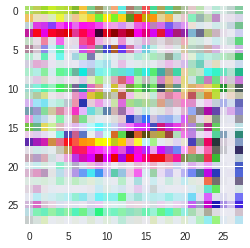

Epoch [29/50], Step [1/10], d_loss: 0.1137, g_loss: 8.5949, D(x): 0.99, D(G(z)): 0.06
Epoch [29/50], Step [2/10], d_loss: 0.1295, g_loss: 8.6911, D(x): 1.00, D(G(z)): 0.07
Epoch [29/50], Step [3/10], d_loss: 0.1266, g_loss: 8.8005, D(x): 1.00, D(G(z)): 0.07
Epoch [29/50], Step [4/10], d_loss: 0.1223, g_loss: 8.8846, D(x): 0.99, D(G(z)): 0.06
Epoch [29/50], Step [5/10], d_loss: 0.1285, g_loss: 8.8356, D(x): 0.99, D(G(z)): 0.06
Epoch [29/50], Step [6/10], d_loss: 0.1176, g_loss: 9.0263, D(x): 0.99, D(G(z)): 0.06
Epoch [29/50], Step [7/10], d_loss: 0.0845, g_loss: 9.0407, D(x): 1.00, D(G(z)): 0.05
Epoch [29/50], Step [8/10], d_loss: 0.0659, g_loss: 9.0912, D(x): 1.00, D(G(z)): 0.04
Epoch [29/50], Step [9/10], d_loss: 0.0606, g_loss: 8.9994, D(x): 1.00, D(G(z)): 0.03
Epoch [29/50], Step [10/10], d_loss: 0.0579, g_loss: 8.8263, D(x): 0.99, D(G(z)): 0.03


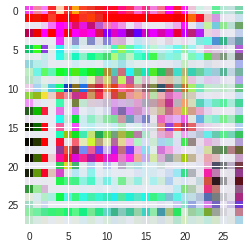

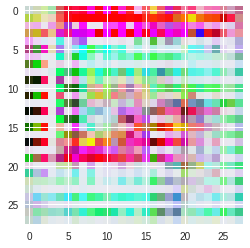

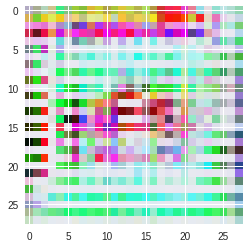

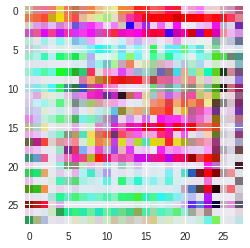

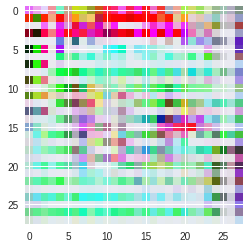

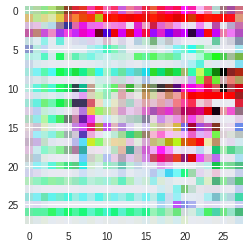

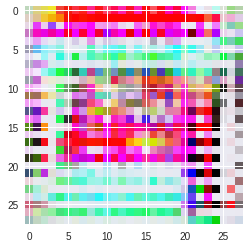

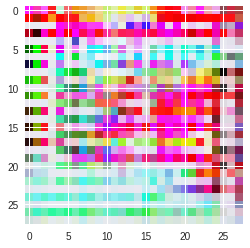

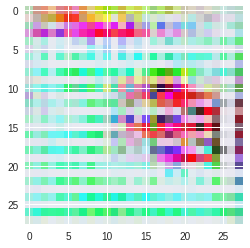

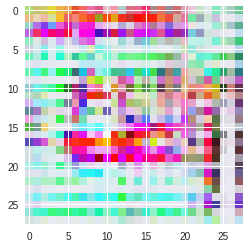

Epoch [30/50], Step [1/10], d_loss: 0.0536, g_loss: 8.5643, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [2/10], d_loss: 0.0521, g_loss: 8.3416, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [3/10], d_loss: 0.0494, g_loss: 8.0885, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [4/10], d_loss: 0.0559, g_loss: 7.7186, D(x): 0.99, D(G(z)): 0.03
Epoch [30/50], Step [5/10], d_loss: 0.0618, g_loss: 7.4172, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [6/10], d_loss: 0.0606, g_loss: 7.1935, D(x): 0.99, D(G(z)): 0.03
Epoch [30/50], Step [7/10], d_loss: 0.0491, g_loss: 6.8487, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [8/10], d_loss: 0.0471, g_loss: 6.5311, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [9/10], d_loss: 0.0484, g_loss: 6.3794, D(x): 1.00, D(G(z)): 0.03
Epoch [30/50], Step [10/10], d_loss: 0.0564, g_loss: 6.2241, D(x): 0.99, D(G(z)): 0.03


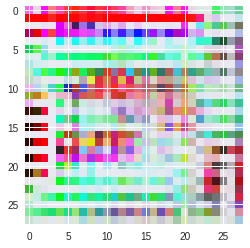

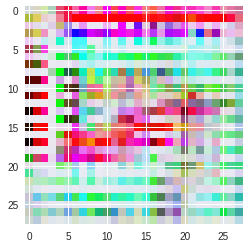

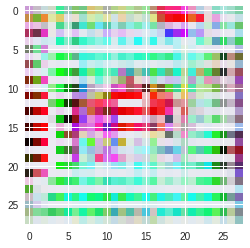

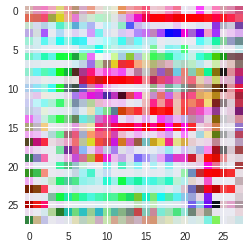

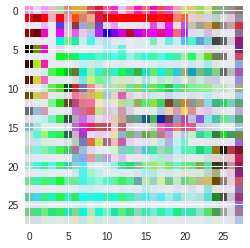

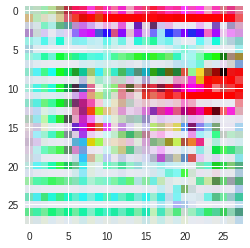

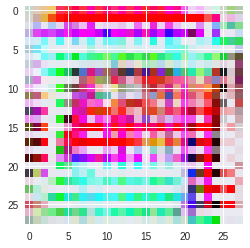

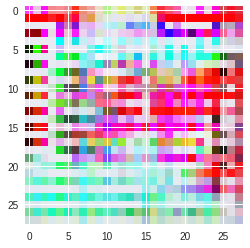

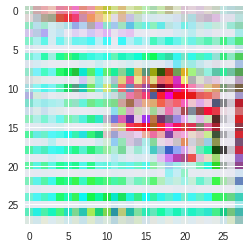

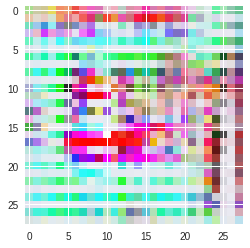

Epoch [31/50], Step [1/10], d_loss: 0.0594, g_loss: 6.0316, D(x): 1.00, D(G(z)): 0.04
Epoch [31/50], Step [2/10], d_loss: 0.0608, g_loss: 5.8932, D(x): 1.00, D(G(z)): 0.04
Epoch [31/50], Step [3/10], d_loss: 0.0590, g_loss: 5.7232, D(x): 1.00, D(G(z)): 0.04
Epoch [31/50], Step [4/10], d_loss: 0.0758, g_loss: 5.6419, D(x): 0.99, D(G(z)): 0.05
Epoch [31/50], Step [5/10], d_loss: 0.0787, g_loss: 5.5439, D(x): 0.99, D(G(z)): 0.05
Epoch [31/50], Step [6/10], d_loss: 0.0777, g_loss: 5.4351, D(x): 1.00, D(G(z)): 0.05
Epoch [31/50], Step [7/10], d_loss: 0.0838, g_loss: 5.3071, D(x): 1.00, D(G(z)): 0.06
Epoch [31/50], Step [8/10], d_loss: 0.0893, g_loss: 5.1691, D(x): 1.00, D(G(z)): 0.07
Epoch [31/50], Step [9/10], d_loss: 0.1041, g_loss: 5.0683, D(x): 1.00, D(G(z)): 0.08
Epoch [31/50], Step [10/10], d_loss: 0.1073, g_loss: 5.0341, D(x): 1.00, D(G(z)): 0.08


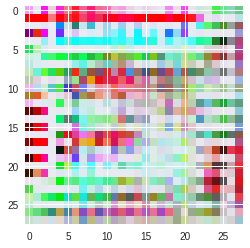

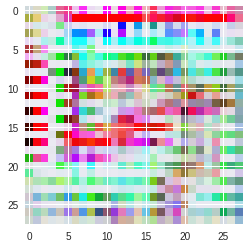

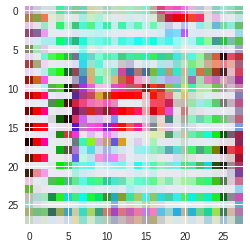

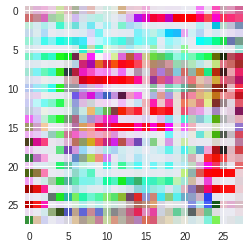

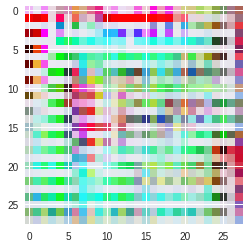

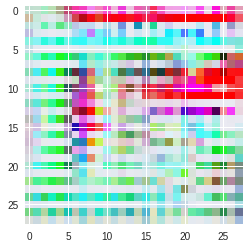

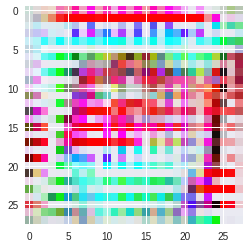

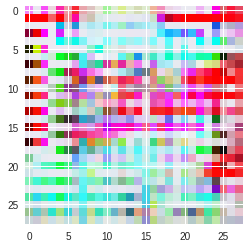

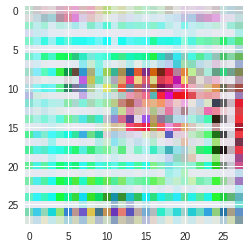

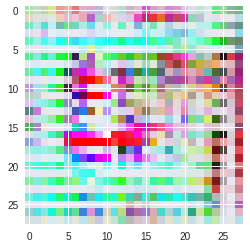

Epoch [32/50], Step [1/10], d_loss: 0.0980, g_loss: 5.0090, D(x): 1.00, D(G(z)): 0.07
Epoch [32/50], Step [2/10], d_loss: 0.1010, g_loss: 5.0229, D(x): 1.00, D(G(z)): 0.07
Epoch [32/50], Step [3/10], d_loss: 0.0979, g_loss: 5.1040, D(x): 0.99, D(G(z)): 0.07
Epoch [32/50], Step [4/10], d_loss: 0.1046, g_loss: 5.0986, D(x): 0.99, D(G(z)): 0.07
Epoch [32/50], Step [5/10], d_loss: 0.0980, g_loss: 5.1667, D(x): 0.99, D(G(z)): 0.07
Epoch [32/50], Step [6/10], d_loss: 0.0889, g_loss: 5.3013, D(x): 0.99, D(G(z)): 0.06
Epoch [32/50], Step [7/10], d_loss: 0.0882, g_loss: 5.3238, D(x): 1.00, D(G(z)): 0.06
Epoch [32/50], Step [8/10], d_loss: 0.0885, g_loss: 5.3462, D(x): 1.00, D(G(z)): 0.07
Epoch [32/50], Step [9/10], d_loss: 0.0833, g_loss: 5.5109, D(x): 1.00, D(G(z)): 0.06
Epoch [32/50], Step [10/10], d_loss: 0.0955, g_loss: 5.4761, D(x): 0.99, D(G(z)): 0.07


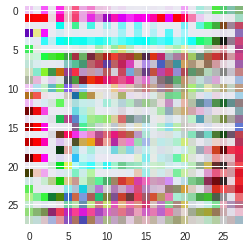

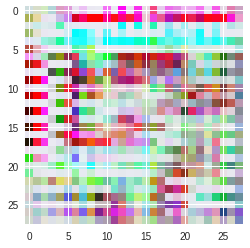

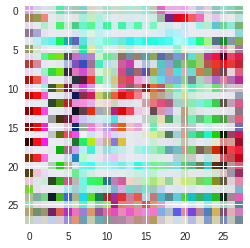

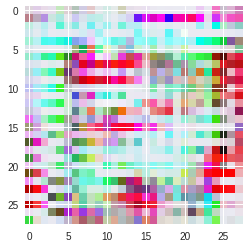

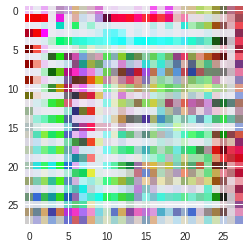

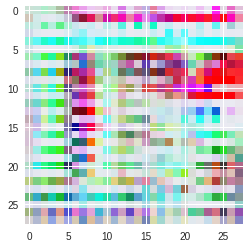

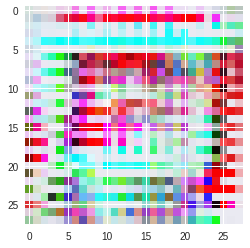

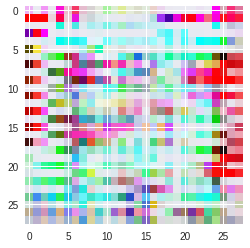

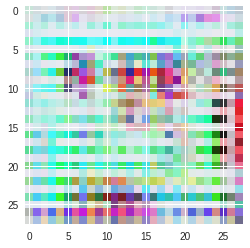

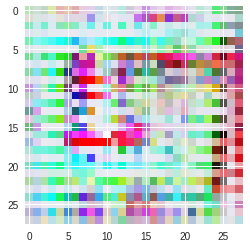

Epoch [33/50], Step [1/10], d_loss: 0.0865, g_loss: 5.5723, D(x): 1.00, D(G(z)): 0.06
Epoch [33/50], Step [2/10], d_loss: 0.1016, g_loss: 5.5190, D(x): 0.99, D(G(z)): 0.07
Epoch [33/50], Step [3/10], d_loss: 0.1018, g_loss: 5.5902, D(x): 0.99, D(G(z)): 0.07
Epoch [33/50], Step [4/10], d_loss: 0.1041, g_loss: 5.6436, D(x): 0.99, D(G(z)): 0.07
Epoch [33/50], Step [5/10], d_loss: 0.0849, g_loss: 5.8289, D(x): 0.99, D(G(z)): 0.06
Epoch [33/50], Step [6/10], d_loss: 0.0759, g_loss: 5.9666, D(x): 1.00, D(G(z)): 0.05
Epoch [33/50], Step [7/10], d_loss: 0.0722, g_loss: 6.0034, D(x): 1.00, D(G(z)): 0.05
Epoch [33/50], Step [8/10], d_loss: 0.0666, g_loss: 5.9890, D(x): 1.00, D(G(z)): 0.05
Epoch [33/50], Step [9/10], d_loss: 0.0664, g_loss: 6.0667, D(x): 1.00, D(G(z)): 0.05
Epoch [33/50], Step [10/10], d_loss: 0.0630, g_loss: 6.2734, D(x): 1.00, D(G(z)): 0.05


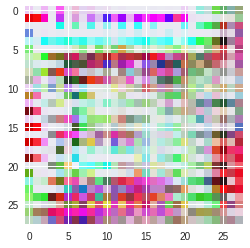

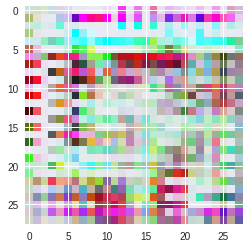

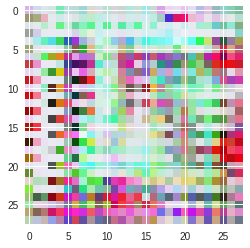

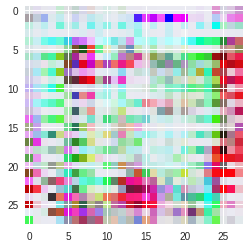

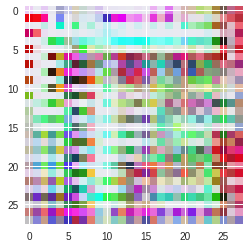

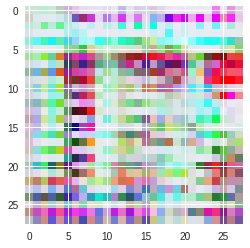

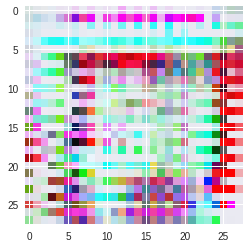

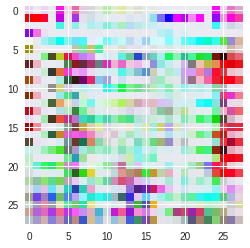

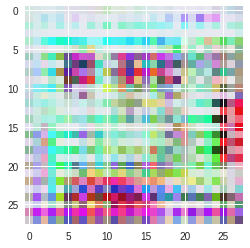

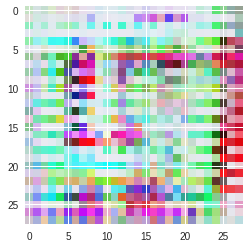

Epoch [34/50], Step [1/10], d_loss: 0.0717, g_loss: 6.1904, D(x): 1.00, D(G(z)): 0.06
Epoch [34/50], Step [2/10], d_loss: 0.0839, g_loss: 6.2358, D(x): 1.00, D(G(z)): 0.06
Epoch [34/50], Step [3/10], d_loss: 0.0777, g_loss: 6.4501, D(x): 1.00, D(G(z)): 0.06
Epoch [34/50], Step [4/10], d_loss: 0.0983, g_loss: 6.4796, D(x): 1.00, D(G(z)): 0.07
Epoch [34/50], Step [5/10], d_loss: 0.0991, g_loss: 6.7964, D(x): 1.00, D(G(z)): 0.07
Epoch [34/50], Step [6/10], d_loss: 0.1004, g_loss: 7.0892, D(x): 1.00, D(G(z)): 0.07
Epoch [34/50], Step [7/10], d_loss: 0.0837, g_loss: 7.4383, D(x): 1.00, D(G(z)): 0.06
Epoch [34/50], Step [8/10], d_loss: 0.0711, g_loss: 7.9301, D(x): 1.00, D(G(z)): 0.05
Epoch [34/50], Step [9/10], d_loss: 0.0579, g_loss: 8.2364, D(x): 1.00, D(G(z)): 0.04
Epoch [34/50], Step [10/10], d_loss: 0.0503, g_loss: 8.4761, D(x): 1.00, D(G(z)): 0.04


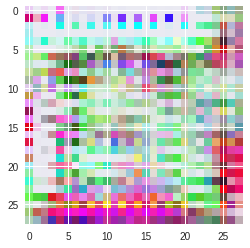

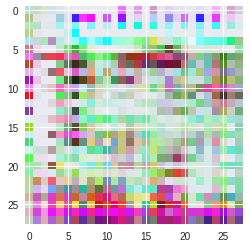

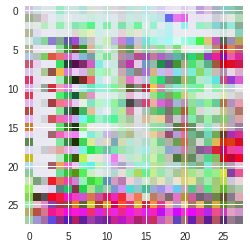

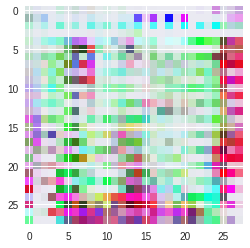

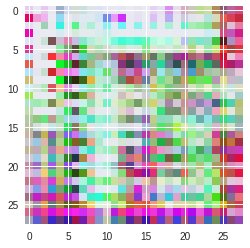

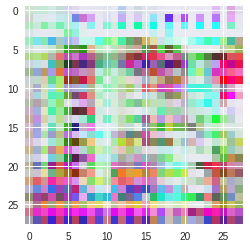

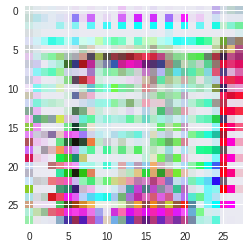

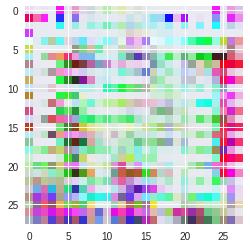

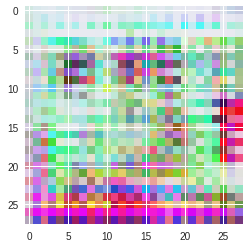

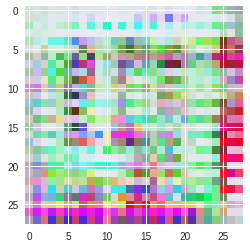

Epoch [35/50], Step [1/10], d_loss: 0.0409, g_loss: 8.6713, D(x): 1.00, D(G(z)): 0.03
Epoch [35/50], Step [2/10], d_loss: 0.0371, g_loss: 8.6994, D(x): 1.00, D(G(z)): 0.03
Epoch [35/50], Step [3/10], d_loss: 0.0331, g_loss: 8.6933, D(x): 1.00, D(G(z)): 0.03
Epoch [35/50], Step [4/10], d_loss: 0.0404, g_loss: 8.5165, D(x): 1.00, D(G(z)): 0.03
Epoch [35/50], Step [5/10], d_loss: 0.0566, g_loss: 8.3411, D(x): 1.00, D(G(z)): 0.04
Epoch [35/50], Step [6/10], d_loss: 0.1162, g_loss: 8.3576, D(x): 1.00, D(G(z)): 0.06
Epoch [35/50], Step [7/10], d_loss: 0.1451, g_loss: 8.7543, D(x): 1.00, D(G(z)): 0.07
Epoch [35/50], Step [8/10], d_loss: 0.1370, g_loss: 9.5746, D(x): 1.00, D(G(z)): 0.07
Epoch [35/50], Step [9/10], d_loss: 0.0859, g_loss: 10.4834, D(x): 1.00, D(G(z)): 0.05
Epoch [35/50], Step [10/10], d_loss: 0.0365, g_loss: 11.3134, D(x): 1.00, D(G(z)): 0.02


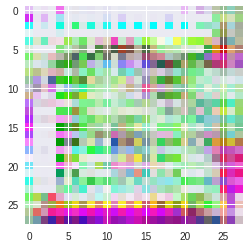

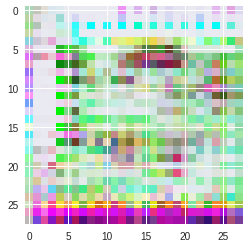

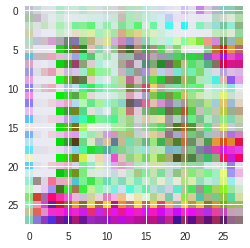

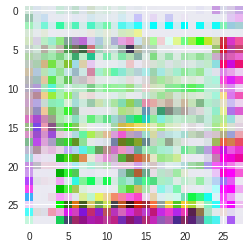

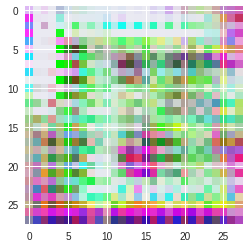

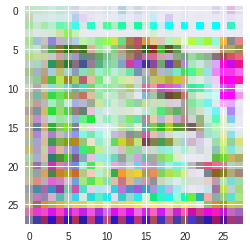

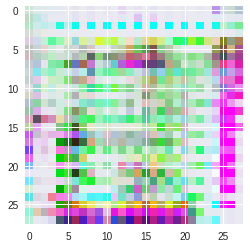

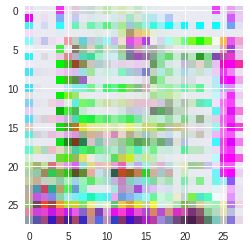

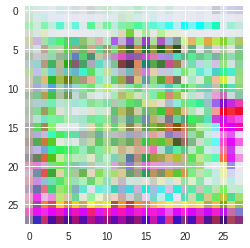

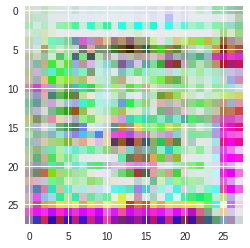

Epoch [36/50], Step [1/10], d_loss: 0.0179, g_loss: 11.8511, D(x): 1.00, D(G(z)): 0.01
Epoch [36/50], Step [2/10], d_loss: 0.0130, g_loss: 12.1410, D(x): 1.00, D(G(z)): 0.01
Epoch [36/50], Step [3/10], d_loss: 0.0107, g_loss: 12.1630, D(x): 1.00, D(G(z)): 0.00
Epoch [36/50], Step [4/10], d_loss: 0.0110, g_loss: 11.9360, D(x): 1.00, D(G(z)): 0.01
Epoch [36/50], Step [5/10], d_loss: 0.0152, g_loss: 11.4570, D(x): 1.00, D(G(z)): 0.01
Epoch [36/50], Step [6/10], d_loss: 0.0201, g_loss: 10.8581, D(x): 1.00, D(G(z)): 0.01
Epoch [36/50], Step [7/10], d_loss: 0.0363, g_loss: 10.0556, D(x): 1.00, D(G(z)): 0.02
Epoch [36/50], Step [8/10], d_loss: 0.0576, g_loss: 9.3272, D(x): 1.00, D(G(z)): 0.03
Epoch [36/50], Step [9/10], d_loss: 0.1100, g_loss: 8.8769, D(x): 1.00, D(G(z)): 0.05
Epoch [36/50], Step [10/10], d_loss: 0.1355, g_loss: 8.9066, D(x): 1.00, D(G(z)): 0.07


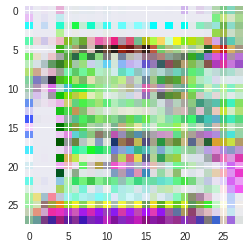

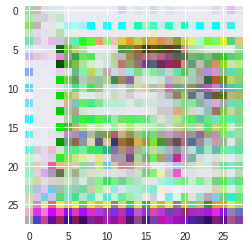

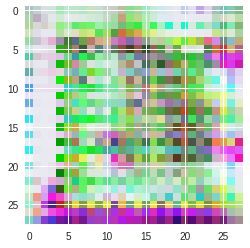

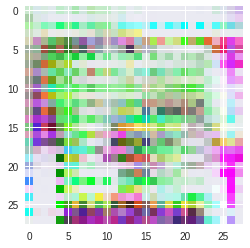

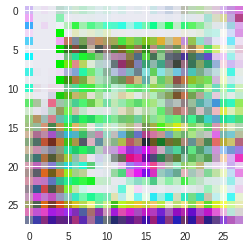

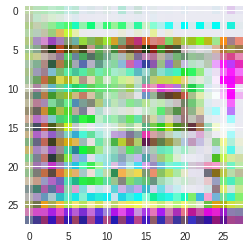

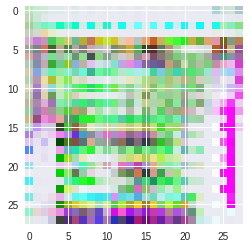

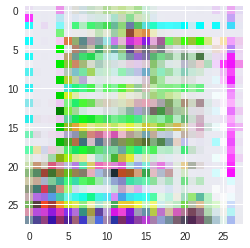

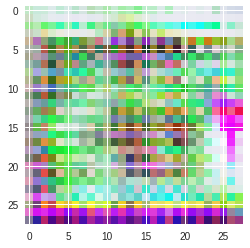

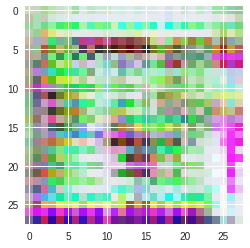

Epoch [37/50], Step [1/10], d_loss: 0.1151, g_loss: 9.2865, D(x): 1.00, D(G(z)): 0.06
Epoch [37/50], Step [2/10], d_loss: 0.0933, g_loss: 9.7346, D(x): 1.00, D(G(z)): 0.05
Epoch [37/50], Step [3/10], d_loss: 0.0597, g_loss: 10.2578, D(x): 1.00, D(G(z)): 0.03
Epoch [37/50], Step [4/10], d_loss: 0.0407, g_loss: 10.7161, D(x): 1.00, D(G(z)): 0.02
Epoch [37/50], Step [5/10], d_loss: 0.0346, g_loss: 10.9277, D(x): 1.00, D(G(z)): 0.02
Epoch [37/50], Step [6/10], d_loss: 0.0234, g_loss: 11.0265, D(x): 1.00, D(G(z)): 0.01
Epoch [37/50], Step [7/10], d_loss: 0.0217, g_loss: 10.9105, D(x): 1.00, D(G(z)): 0.01
Epoch [37/50], Step [8/10], d_loss: 0.0176, g_loss: 10.6148, D(x): 1.00, D(G(z)): 0.01
Epoch [37/50], Step [9/10], d_loss: 0.0258, g_loss: 10.1203, D(x): 1.00, D(G(z)): 0.01
Epoch [37/50], Step [10/10], d_loss: 0.0287, g_loss: 9.5368, D(x): 1.00, D(G(z)): 0.02


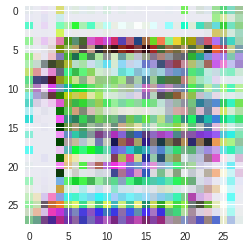

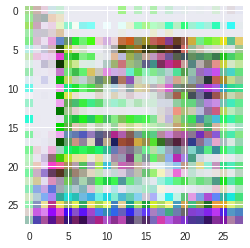

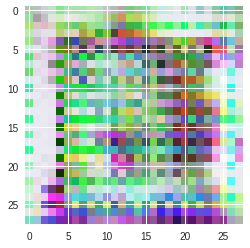

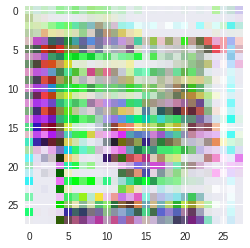

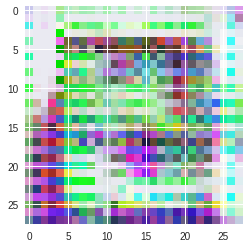

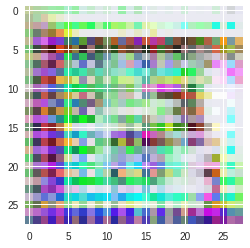

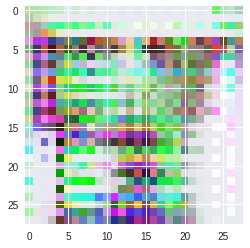

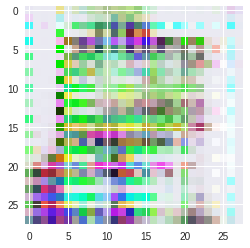

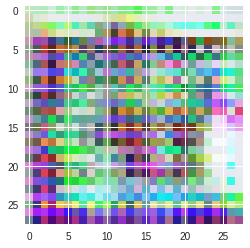

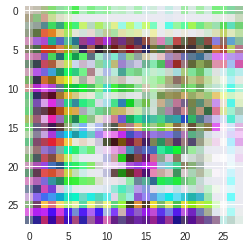

Epoch [38/50], Step [1/10], d_loss: 0.0315, g_loss: 8.9525, D(x): 1.00, D(G(z)): 0.02
Epoch [38/50], Step [2/10], d_loss: 0.0480, g_loss: 8.3038, D(x): 1.00, D(G(z)): 0.03
Epoch [38/50], Step [3/10], d_loss: 0.0689, g_loss: 7.7634, D(x): 1.00, D(G(z)): 0.04
Epoch [38/50], Step [4/10], d_loss: 0.0787, g_loss: 7.4715, D(x): 1.00, D(G(z)): 0.05
Epoch [38/50], Step [5/10], d_loss: 0.0951, g_loss: 7.3084, D(x): 1.00, D(G(z)): 0.06
Epoch [38/50], Step [6/10], d_loss: 0.0997, g_loss: 7.3354, D(x): 1.00, D(G(z)): 0.06
Epoch [38/50], Step [7/10], d_loss: 0.0904, g_loss: 7.4770, D(x): 1.00, D(G(z)): 0.06
Epoch [38/50], Step [8/10], d_loss: 0.0808, g_loss: 7.6444, D(x): 1.00, D(G(z)): 0.05
Epoch [38/50], Step [9/10], d_loss: 0.0800, g_loss: 7.7475, D(x): 1.00, D(G(z)): 0.05
Epoch [38/50], Step [10/10], d_loss: 0.0784, g_loss: 7.8216, D(x): 1.00, D(G(z)): 0.05


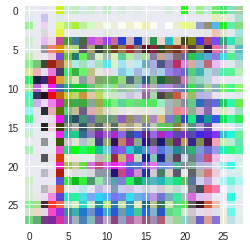

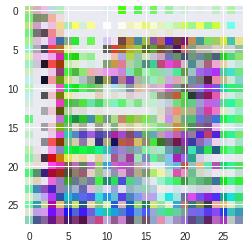

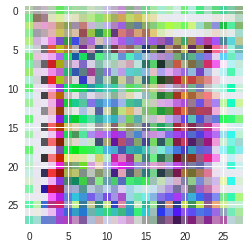

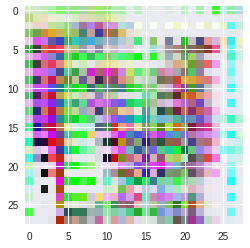

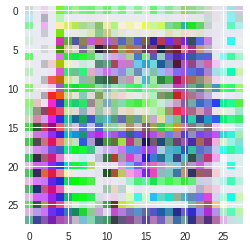

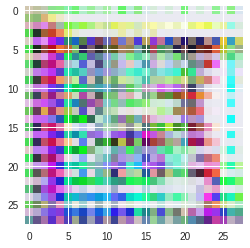

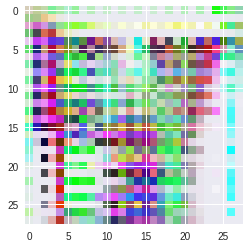

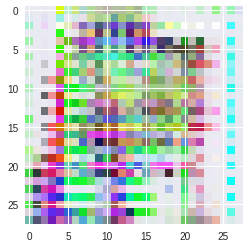

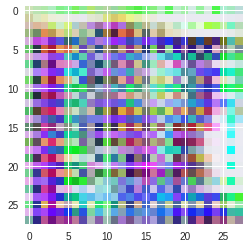

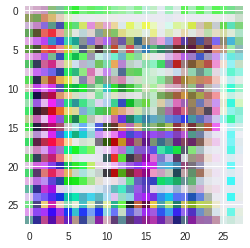

Epoch [39/50], Step [1/10], d_loss: 0.0681, g_loss: 7.8792, D(x): 1.00, D(G(z)): 0.05
Epoch [39/50], Step [2/10], d_loss: 0.0804, g_loss: 7.8642, D(x): 1.00, D(G(z)): 0.05
Epoch [39/50], Step [3/10], d_loss: 0.0881, g_loss: 7.8365, D(x): 1.00, D(G(z)): 0.06
Epoch [39/50], Step [4/10], d_loss: 0.0950, g_loss: 7.8844, D(x): 0.99, D(G(z)): 0.06
Epoch [39/50], Step [5/10], d_loss: 0.1148, g_loss: 7.7799, D(x): 0.99, D(G(z)): 0.07
Epoch [39/50], Step [6/10], d_loss: 0.1221, g_loss: 7.9013, D(x): 0.99, D(G(z)): 0.07
Epoch [39/50], Step [7/10], d_loss: 0.1389, g_loss: 7.8907, D(x): 0.99, D(G(z)): 0.08
Epoch [39/50], Step [8/10], d_loss: 0.1412, g_loss: 8.1203, D(x): 0.99, D(G(z)): 0.08
Epoch [39/50], Step [9/10], d_loss: 0.1499, g_loss: 8.3645, D(x): 0.99, D(G(z)): 0.08
Epoch [39/50], Step [10/10], d_loss: 0.1516, g_loss: 8.5767, D(x): 0.99, D(G(z)): 0.08


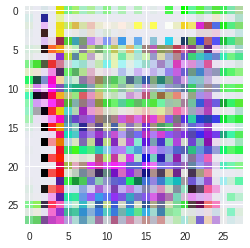

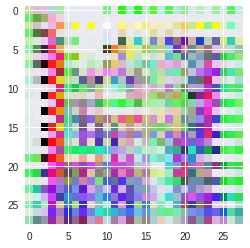

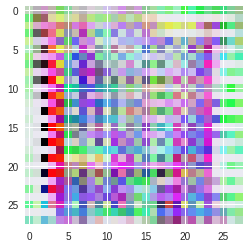

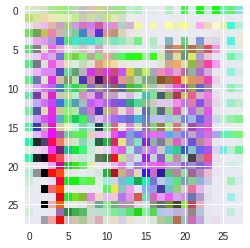

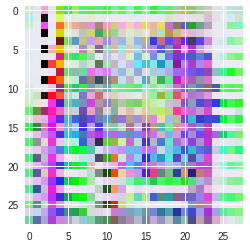

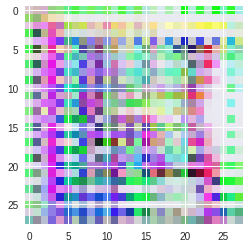

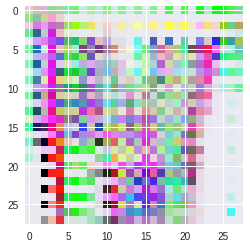

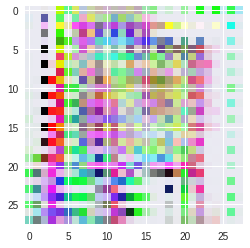

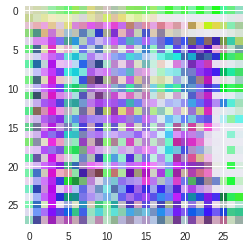

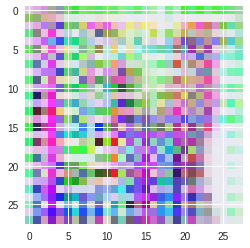

Epoch [40/50], Step [1/10], d_loss: 0.1414, g_loss: 8.8651, D(x): 0.99, D(G(z)): 0.08
Epoch [40/50], Step [2/10], d_loss: 0.1327, g_loss: 9.1857, D(x): 0.99, D(G(z)): 0.07
Epoch [40/50], Step [3/10], d_loss: 0.1225, g_loss: 9.5516, D(x): 0.99, D(G(z)): 0.06
Epoch [40/50], Step [4/10], d_loss: 0.1216, g_loss: 9.7644, D(x): 0.99, D(G(z)): 0.06
Epoch [40/50], Step [5/10], d_loss: 0.1125, g_loss: 9.9641, D(x): 0.99, D(G(z)): 0.05
Epoch [40/50], Step [6/10], d_loss: 0.0994, g_loss: 10.0411, D(x): 0.99, D(G(z)): 0.05
Epoch [40/50], Step [7/10], d_loss: 0.1056, g_loss: 9.9771, D(x): 0.99, D(G(z)): 0.05
Epoch [40/50], Step [8/10], d_loss: 0.1032, g_loss: 9.9007, D(x): 0.99, D(G(z)): 0.05
Epoch [40/50], Step [9/10], d_loss: 0.1150, g_loss: 9.9044, D(x): 0.99, D(G(z)): 0.05
Epoch [40/50], Step [10/10], d_loss: 0.1223, g_loss: 10.0172, D(x): 0.99, D(G(z)): 0.06


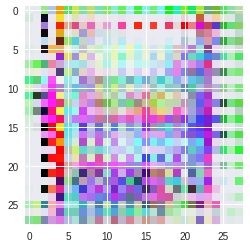

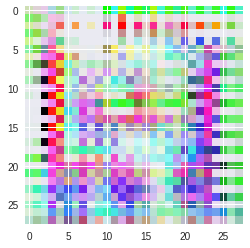

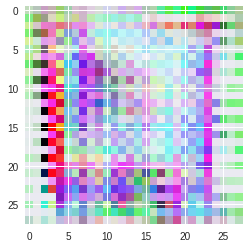

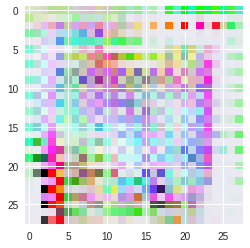

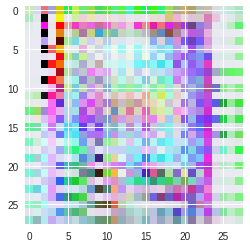

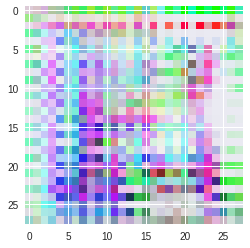

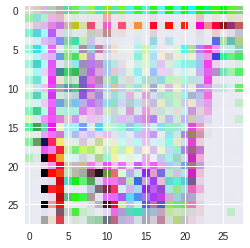

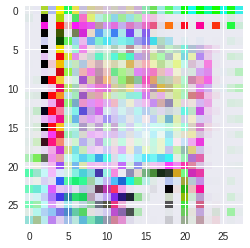

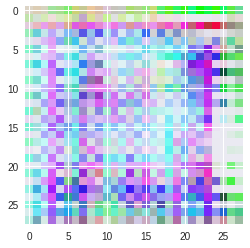

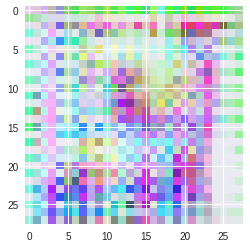

Epoch [41/50], Step [1/10], d_loss: 0.1039, g_loss: 10.3040, D(x): 1.00, D(G(z)): 0.05
Epoch [41/50], Step [2/10], d_loss: 0.0848, g_loss: 10.4648, D(x): 1.00, D(G(z)): 0.05
Epoch [41/50], Step [3/10], d_loss: 0.0619, g_loss: 10.6988, D(x): 1.00, D(G(z)): 0.04
Epoch [41/50], Step [4/10], d_loss: 0.0534, g_loss: 10.8246, D(x): 1.00, D(G(z)): 0.03
Epoch [41/50], Step [5/10], d_loss: 0.0391, g_loss: 10.9241, D(x): 1.00, D(G(z)): 0.02
Epoch [41/50], Step [6/10], d_loss: 0.0268, g_loss: 10.8199, D(x): 1.00, D(G(z)): 0.02
Epoch [41/50], Step [7/10], d_loss: 0.0269, g_loss: 10.6350, D(x): 1.00, D(G(z)): 0.01
Epoch [41/50], Step [8/10], d_loss: 0.0258, g_loss: 10.3456, D(x): 1.00, D(G(z)): 0.02
Epoch [41/50], Step [9/10], d_loss: 0.0318, g_loss: 9.8140, D(x): 1.00, D(G(z)): 0.02
Epoch [41/50], Step [10/10], d_loss: 0.0355, g_loss: 9.4071, D(x): 1.00, D(G(z)): 0.02


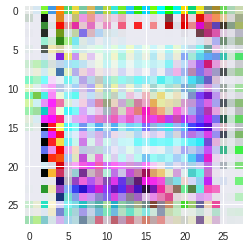

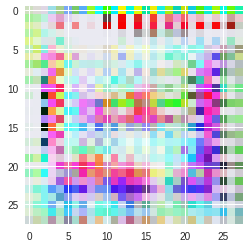

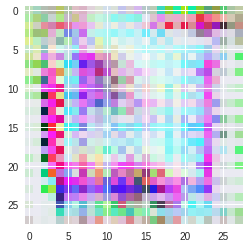

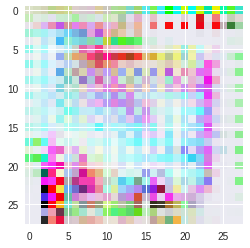

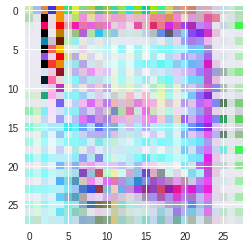

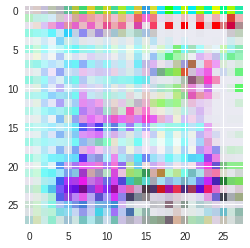

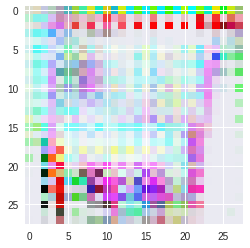

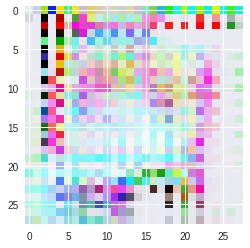

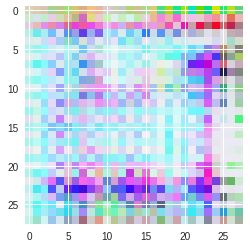

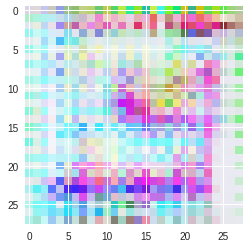

Epoch [42/50], Step [1/10], d_loss: 0.0498, g_loss: 8.8581, D(x): 1.00, D(G(z)): 0.03
Epoch [42/50], Step [2/10], d_loss: 0.0716, g_loss: 8.5110, D(x): 1.00, D(G(z)): 0.04
Epoch [42/50], Step [3/10], d_loss: 0.0939, g_loss: 8.4121, D(x): 1.00, D(G(z)): 0.05
Epoch [42/50], Step [4/10], d_loss: 0.1125, g_loss: 8.4995, D(x): 1.00, D(G(z)): 0.06
Epoch [42/50], Step [5/10], d_loss: 0.1118, g_loss: 8.8164, D(x): 1.00, D(G(z)): 0.06
Epoch [42/50], Step [6/10], d_loss: 0.1156, g_loss: 9.3289, D(x): 1.00, D(G(z)): 0.06
Epoch [42/50], Step [7/10], d_loss: 0.1011, g_loss: 9.9901, D(x): 1.00, D(G(z)): 0.05
Epoch [42/50], Step [8/10], d_loss: 0.0946, g_loss: 10.6729, D(x): 0.99, D(G(z)): 0.05
Epoch [42/50], Step [9/10], d_loss: 0.0677, g_loss: 11.2879, D(x): 0.99, D(G(z)): 0.03
Epoch [42/50], Step [10/10], d_loss: 0.0922, g_loss: 11.6017, D(x): 0.99, D(G(z)): 0.03


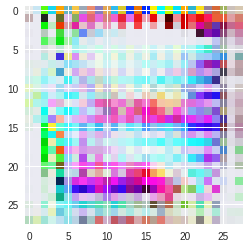

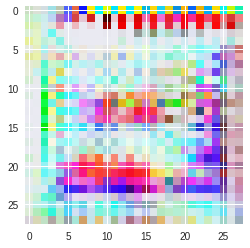

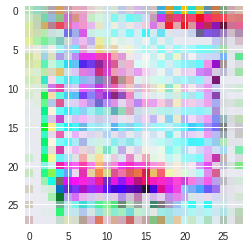

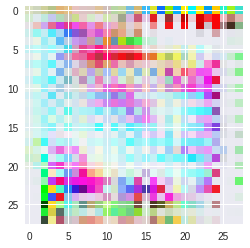

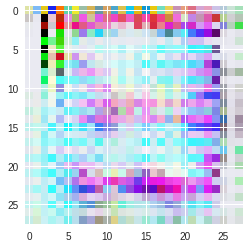

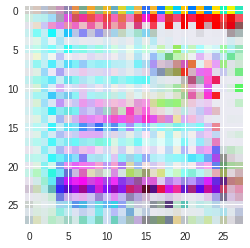

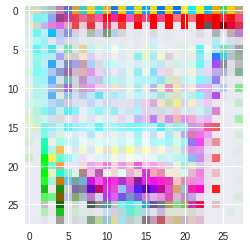

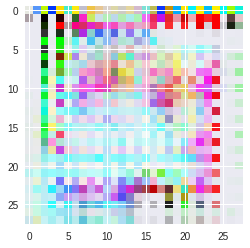

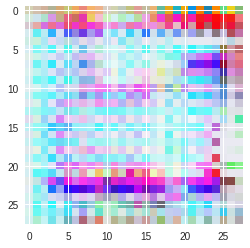

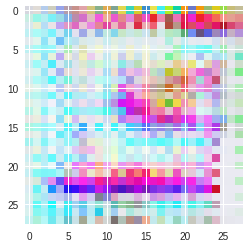

Epoch [43/50], Step [1/10], d_loss: 0.0747, g_loss: 11.9096, D(x): 0.99, D(G(z)): 0.03
Epoch [43/50], Step [2/10], d_loss: 0.1090, g_loss: 11.9396, D(x): 0.98, D(G(z)): 0.03
Epoch [43/50], Step [3/10], d_loss: 0.1337, g_loss: 11.8989, D(x): 0.97, D(G(z)): 0.03
Epoch [43/50], Step [4/10], d_loss: 0.1794, g_loss: 11.6498, D(x): 0.96, D(G(z)): 0.04
Epoch [43/50], Step [5/10], d_loss: 0.1867, g_loss: 11.3814, D(x): 0.97, D(G(z)): 0.05
Epoch [43/50], Step [6/10], d_loss: 0.1756, g_loss: 11.3269, D(x): 0.98, D(G(z)): 0.05
Epoch [43/50], Step [7/10], d_loss: 0.1680, g_loss: 11.1957, D(x): 0.98, D(G(z)): 0.05
Epoch [43/50], Step [8/10], d_loss: 0.1404, g_loss: 11.2889, D(x): 0.99, D(G(z)): 0.05
Epoch [43/50], Step [9/10], d_loss: 0.1253, g_loss: 11.3702, D(x): 0.99, D(G(z)): 0.05
Epoch [43/50], Step [10/10], d_loss: 0.1138, g_loss: 11.2825, D(x): 0.99, D(G(z)): 0.04


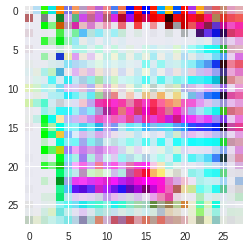

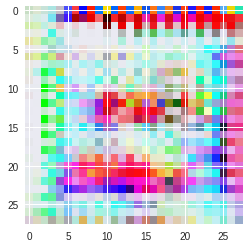

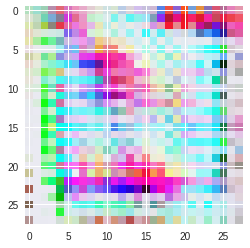

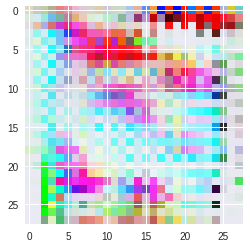

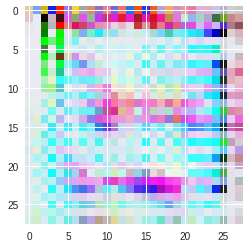

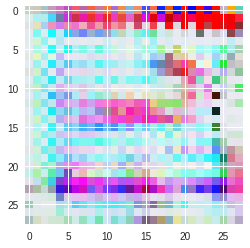

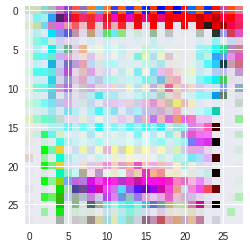

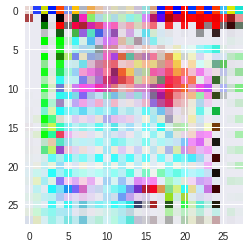

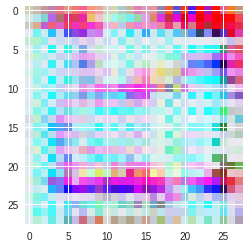

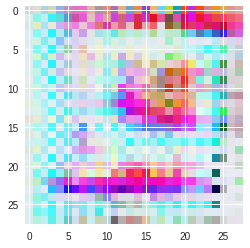

Epoch [44/50], Step [1/10], d_loss: 0.0811, g_loss: 11.2948, D(x): 0.99, D(G(z)): 0.03
Epoch [44/50], Step [2/10], d_loss: 0.0851, g_loss: 11.1650, D(x): 0.99, D(G(z)): 0.03
Epoch [44/50], Step [3/10], d_loss: 0.0844, g_loss: 11.2679, D(x): 0.99, D(G(z)): 0.02
Epoch [44/50], Step [4/10], d_loss: 0.0854, g_loss: 11.1308, D(x): 0.98, D(G(z)): 0.02
Epoch [44/50], Step [5/10], d_loss: 0.0683, g_loss: 10.8902, D(x): 0.99, D(G(z)): 0.02
Epoch [44/50], Step [6/10], d_loss: 0.0741, g_loss: 10.6056, D(x): 0.99, D(G(z)): 0.02
Epoch [44/50], Step [7/10], d_loss: 0.0632, g_loss: 10.2939, D(x): 0.99, D(G(z)): 0.02
Epoch [44/50], Step [8/10], d_loss: 0.0713, g_loss: 10.0707, D(x): 0.99, D(G(z)): 0.03
Epoch [44/50], Step [9/10], d_loss: 0.0649, g_loss: 9.6222, D(x): 0.99, D(G(z)): 0.03
Epoch [44/50], Step [10/10], d_loss: 0.0771, g_loss: 9.3757, D(x): 0.99, D(G(z)): 0.03


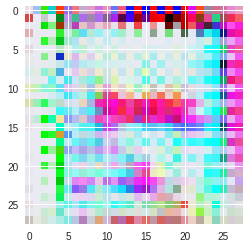

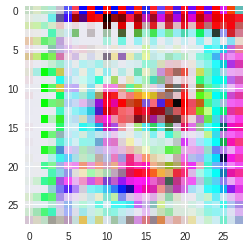

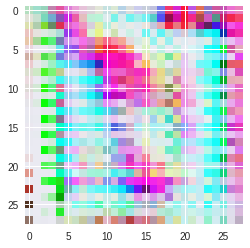

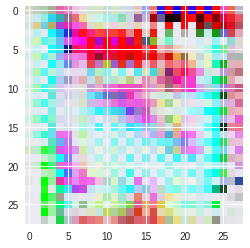

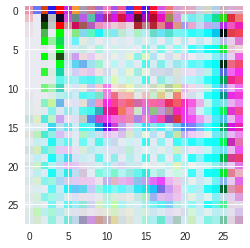

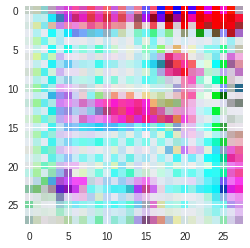

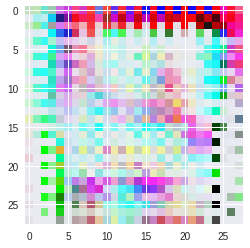

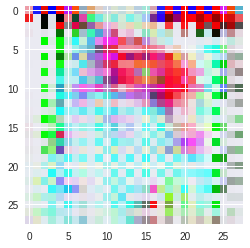

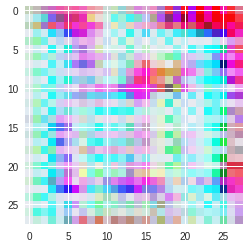

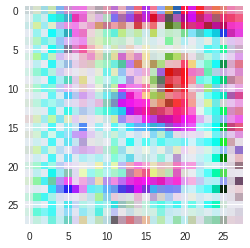

Epoch [45/50], Step [1/10], d_loss: 0.0670, g_loss: 9.0944, D(x): 1.00, D(G(z)): 0.04
Epoch [45/50], Step [2/10], d_loss: 0.0712, g_loss: 8.8462, D(x): 1.00, D(G(z)): 0.04
Epoch [45/50], Step [3/10], d_loss: 0.0861, g_loss: 8.5616, D(x): 0.99, D(G(z)): 0.04
Epoch [45/50], Step [4/10], d_loss: 0.0972, g_loss: 8.4472, D(x): 0.99, D(G(z)): 0.04
Epoch [45/50], Step [5/10], d_loss: 0.0828, g_loss: 8.3340, D(x): 0.99, D(G(z)): 0.04
Epoch [45/50], Step [6/10], d_loss: 0.1023, g_loss: 8.0980, D(x): 1.00, D(G(z)): 0.05
Epoch [45/50], Step [7/10], d_loss: 0.1021, g_loss: 8.0620, D(x): 1.00, D(G(z)): 0.05
Epoch [45/50], Step [8/10], d_loss: 0.1060, g_loss: 8.1787, D(x): 0.99, D(G(z)): 0.05
Epoch [45/50], Step [9/10], d_loss: 0.0927, g_loss: 8.2292, D(x): 1.00, D(G(z)): 0.05
Epoch [45/50], Step [10/10], d_loss: 0.1020, g_loss: 8.2723, D(x): 0.99, D(G(z)): 0.04


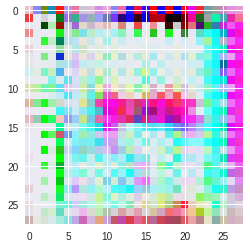

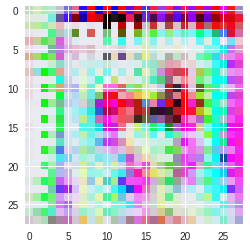

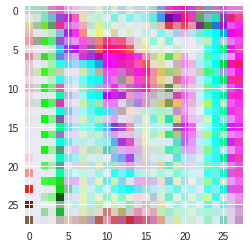

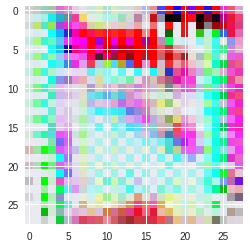

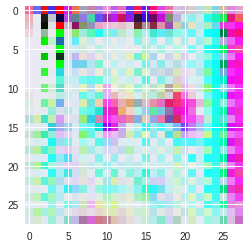

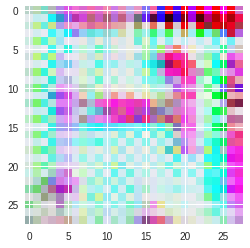

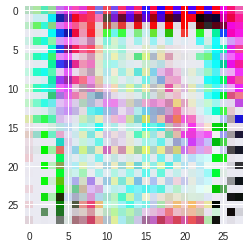

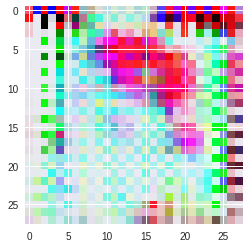

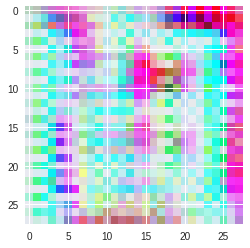

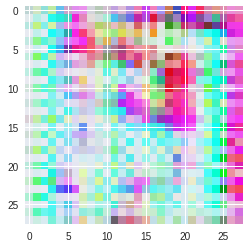

Epoch [46/50], Step [1/10], d_loss: 0.0804, g_loss: 8.3345, D(x): 1.00, D(G(z)): 0.04
Epoch [46/50], Step [2/10], d_loss: 0.0834, g_loss: 8.4172, D(x): 0.99, D(G(z)): 0.04
Epoch [46/50], Step [3/10], d_loss: 0.0882, g_loss: 8.4792, D(x): 0.99, D(G(z)): 0.04
Epoch [46/50], Step [4/10], d_loss: 0.0907, g_loss: 8.5614, D(x): 0.99, D(G(z)): 0.03
Epoch [46/50], Step [5/10], d_loss: 0.0726, g_loss: 8.4822, D(x): 0.99, D(G(z)): 0.03
Epoch [46/50], Step [6/10], d_loss: 0.0572, g_loss: 8.5399, D(x): 0.99, D(G(z)): 0.03
Epoch [46/50], Step [7/10], d_loss: 0.0508, g_loss: 8.5047, D(x): 1.00, D(G(z)): 0.03
Epoch [46/50], Step [8/10], d_loss: 0.0497, g_loss: 8.5527, D(x): 0.99, D(G(z)): 0.02
Epoch [46/50], Step [9/10], d_loss: 0.0396, g_loss: 8.5384, D(x): 1.00, D(G(z)): 0.02
Epoch [46/50], Step [10/10], d_loss: 0.0385, g_loss: 8.4478, D(x): 0.99, D(G(z)): 0.02


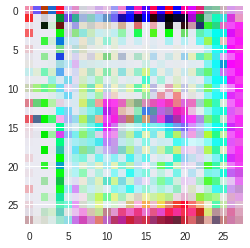

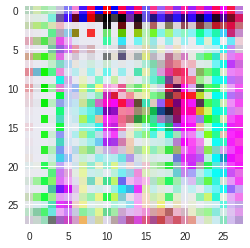

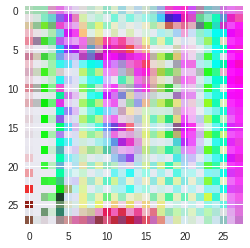

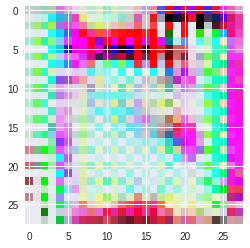

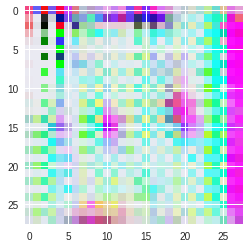

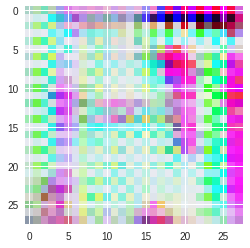

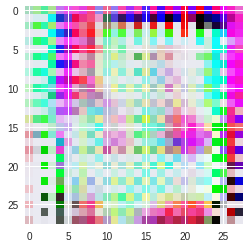

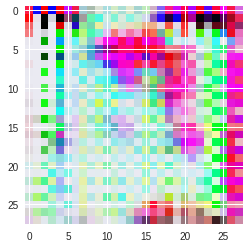

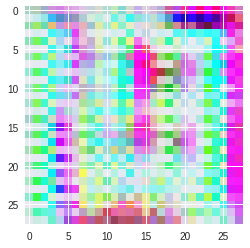

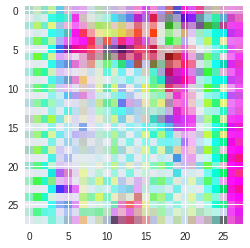

Epoch [47/50], Step [1/10], d_loss: 0.0233, g_loss: 8.4988, D(x): 1.00, D(G(z)): 0.02
Epoch [47/50], Step [2/10], d_loss: 0.0251, g_loss: 8.3907, D(x): 1.00, D(G(z)): 0.02
Epoch [47/50], Step [3/10], d_loss: 0.0244, g_loss: 8.2714, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [4/10], d_loss: 0.0240, g_loss: 8.2251, D(x): 0.99, D(G(z)): 0.01
Epoch [47/50], Step [5/10], d_loss: 0.0198, g_loss: 8.1186, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [6/10], d_loss: 0.0161, g_loss: 7.9861, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [7/10], d_loss: 0.0152, g_loss: 7.7896, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [8/10], d_loss: 0.0187, g_loss: 7.6212, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [9/10], d_loss: 0.0169, g_loss: 7.4534, D(x): 1.00, D(G(z)): 0.01
Epoch [47/50], Step [10/10], d_loss: 0.0220, g_loss: 7.3147, D(x): 1.00, D(G(z)): 0.01


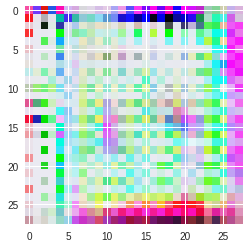

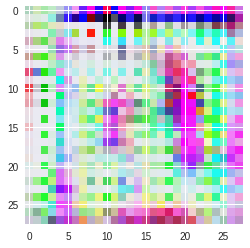

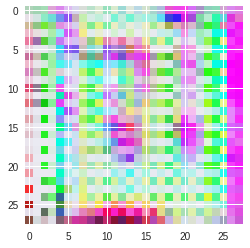

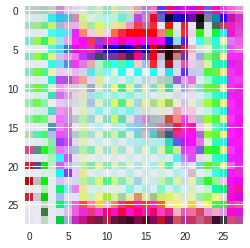

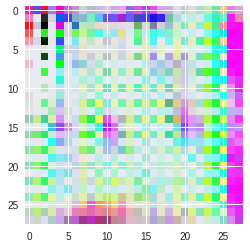

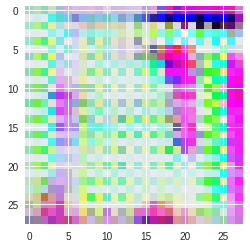

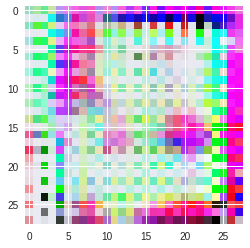

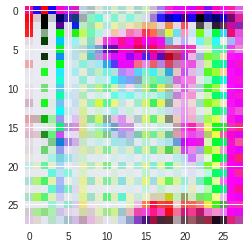

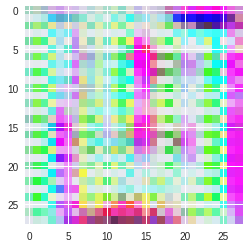

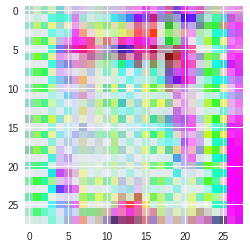

Epoch [48/50], Step [1/10], d_loss: 0.0193, g_loss: 7.1567, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [2/10], d_loss: 0.0206, g_loss: 7.0202, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [3/10], d_loss: 0.0240, g_loss: 6.8388, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [4/10], d_loss: 0.0278, g_loss: 6.8103, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [5/10], d_loss: 0.0291, g_loss: 6.7715, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [6/10], d_loss: 0.0254, g_loss: 6.7598, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [7/10], d_loss: 0.0252, g_loss: 6.7661, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [8/10], d_loss: 0.0271, g_loss: 6.7878, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [9/10], d_loss: 0.0265, g_loss: 6.8089, D(x): 1.00, D(G(z)): 0.02
Epoch [48/50], Step [10/10], d_loss: 0.0301, g_loss: 6.8468, D(x): 1.00, D(G(z)): 0.02


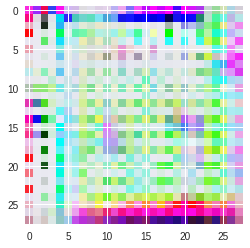

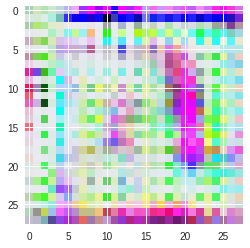

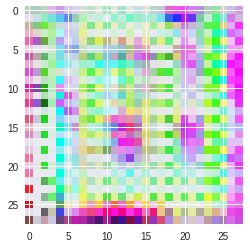

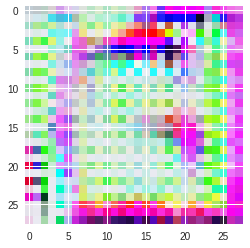

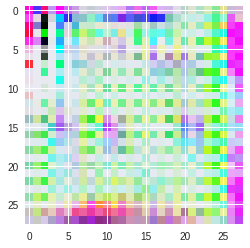

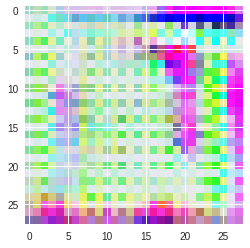

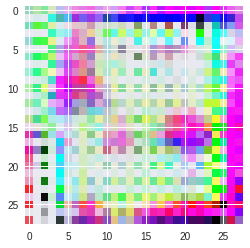

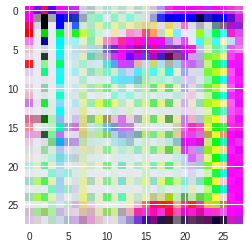

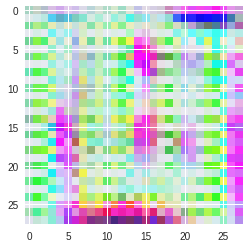

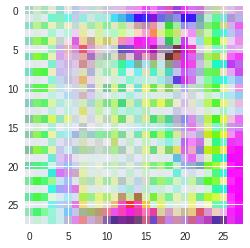

Epoch [49/50], Step [1/10], d_loss: 0.0271, g_loss: 6.9199, D(x): 1.00, D(G(z)): 0.02
Epoch [49/50], Step [2/10], d_loss: 0.0289, g_loss: 6.9479, D(x): 1.00, D(G(z)): 0.02
Epoch [49/50], Step [3/10], d_loss: 0.0280, g_loss: 6.9711, D(x): 1.00, D(G(z)): 0.02
Epoch [49/50], Step [4/10], d_loss: 0.0336, g_loss: 6.9912, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [5/10], d_loss: 0.0369, g_loss: 7.0476, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [6/10], d_loss: 0.0363, g_loss: 7.0901, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [7/10], d_loss: 0.0362, g_loss: 7.1765, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [8/10], d_loss: 0.0431, g_loss: 7.3332, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [9/10], d_loss: 0.0378, g_loss: 7.3689, D(x): 1.00, D(G(z)): 0.03
Epoch [49/50], Step [10/10], d_loss: 0.0347, g_loss: 7.6131, D(x): 1.00, D(G(z)): 0.03


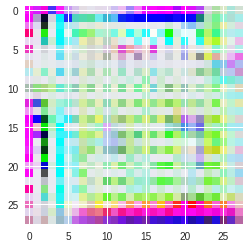

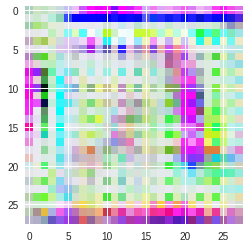

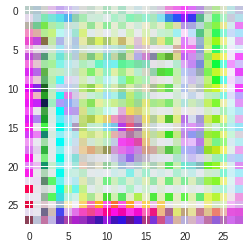

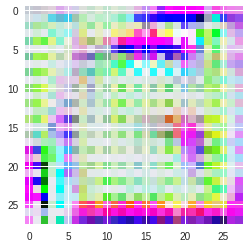

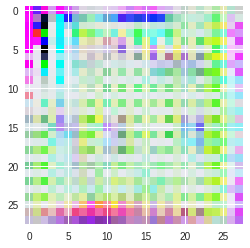

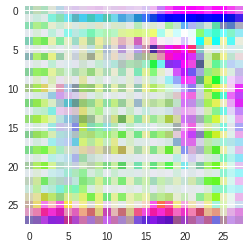

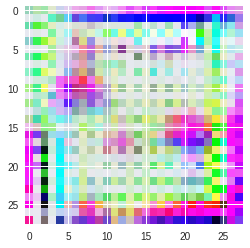

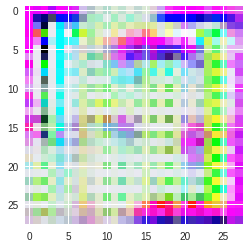

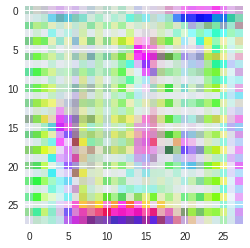

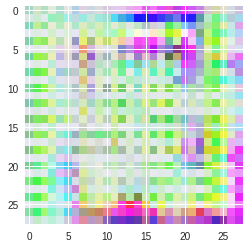

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

G.apply(weights_init)
D.apply(weights_init)


num_epochs = 50

batch_size = 5000

criterion = nn.BCELoss()

# Create the labels which are later used as input for the BCE loss
real_labels = torch.ones((batch_size, 1, 1, 1), device=device)
fake_labels = torch.zeros((batch_size, 1, 1, 1), device=device)
fixed_noise = torch.randn(batch_size, *latent_shape).to(device)

# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        D.zero_grad()
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        noise = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(noise)
        outputs = D(fake_images.detach()) # Don't make a gradient update through G yet
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        del d_loss_real, d_loss_fake
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Compute loss with fake images
        G.zero_grad()
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    #torch.save(G.state_dict(), 'G.ckpt')
    #torch.save(D.state_dict(), 'D.ckpt')

    # Output first two real images
    if (epoch+1) == 1:
        for image in denorm(images).cpu().numpy()[:2]:
            plt.figure()
            plt.imshow(np.moveaxis(image, 0, -1))
            plt.show()
    
    # Save sampled images
    for image in denorm(G(fixed_noise)).cpu().detach().numpy()[:10]:
        plt.figure()
        plt.imshow(np.moveaxis(image, 0, -1))
        plt.show()
